# LLM-Based Pseudo-Factor Analysis (Guenole et al. Methodology)

**Psychometric scale validation using transformer embeddings and exploratory factor analysis**

## Overview

This notebook implements the Pseudo-Factor Analysis (PFA) approach from Guenole et al. for validating psychological scales using pre-trained language model embeddings:

### Key Steps:
1. **Atomic-Reversed Encoding**: Apply item scoring direction (+1/-1) to embeddings
2. **Cosine Similarity Matrix**: Treat normalized similarities as pseudo-correlations
3. **Exploratory Factor Analysis**: ML extraction with oblique rotation
4. **Psychometric Diagnostics**: DAAL, Tucker congruence, KMO/Bartlett tests

### Methodological Choices (Guenole et al.):
- **Extraction**: Maximum Likelihood (ML) - not principal components
- **Rotation**: Oblique (Promax/Oblimin) to allow factor correlations
- **Input**: Cosine similarity of atomic-reversed embeddings
- **Validation**: DAAL, Tucker φ, KMO, Bartlett

### References:
- Guenole, N., et al. (2024). Pre-trained language models for psychometric validation.

---

## Import Dependencies

Import all required libraries for PFA analysis.

In [47]:
import os
import sys
from datetime import datetime
import warnings

# Suppress specific warnings
warnings.filterwarnings('ignore', message='.*Moore-Penrose.*')
warnings.filterwarnings('ignore', message='.*invalid value encountered in log.*')
warnings.filterwarnings('ignore', message=".*'force_all_finite' was renamed.*")

# Set HuggingFace cache directory BEFORE importing transformers/sentence_transformers
os.environ['HF_HOME'] = '/Users/devon7y/.cache/huggingface'
os.environ['HF_DATASETS_CACHE'] = '/Users/devon7y/.cache/huggingface'
# Load HF token from standard cache location
with open(os.path.expanduser('~/.cache/huggingface/token'), 'r') as f:
    os.environ['HF_TOKEN'] = f.read().strip()

import pandas as pd
import numpy as np
import torch

from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from scipy.stats import percentileofscore
import scipy.stats as stats
from skbio.stats.distance import mantel

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

In [48]:
# ==============================================================================
# FIX WORKING DIRECTORY
# ==============================================================================
# Ensure we're in the correct directory for relative paths
import os
from pathlib import Path

# Get the directory containing this notebook
notebook_dir = Path.cwd()
if notebook_dir.name != 'LLM_Factor_Analysis':
    # We're in the wrong directory, change to LLM_Factor_Analysis
    correct_dir = Path('/Users/devon7y/VS Code/LLM_Factor_Analysis')
    if correct_dir.exists():
        os.chdir(correct_dir)
        print(f'Changed working directory to: {os.getcwd()}')
    else:
        print(f'Warning: Expected directory not found: {correct_dir}')
else:
    print(f'Working directory is correct: {os.getcwd()}')


In [49]:
# Configure font sizes (25% increase for better readability)
# IMPORTANT: Run this cell before generating any plots!

# Matplotlib rcParams for standard plots
plt.rcParams.update({
    'font.size': 13,           # Base font size (default 10 → 12.5 ≈ 13)
    'axes.titlesize': 15,      # Subplot titles (default 12 → 15)
    'axes.labelsize': 13,      # Axis labels (default 10 → 12.5 ≈ 13)
    'xtick.labelsize': 12,     # X-axis tick labels (default 10 → 12.5 ≈ 12)
    'ytick.labelsize': 12,     # Y-axis tick labels (default 10 → 12.5 ≈ 12)
    'legend.fontsize': 11,     # Legend text (default 9 → 11.25 ≈ 11)
    'figure.titlesize': 20,    # Suptitle (default 16 → 20)
})

# Seaborn context for heatmaps and seaborn plots
# font_scale=1.25 increases all seaborn fonts by 25%
sns.set_context("notebook", font_scale=1.25)

# Additional width to add between subplots in COMPARISON plots
# This adds extra figure width without squishing the plots
COMPARISON_SUBPLOT_SPACING = 1  # Extra width in inches (default: 3)


## Configuration

Set all parameters for the analysis.

In [50]:
# ==============================================================================
# MODEL SELECTION
# ==============================================================================

MODEL_NAMES = [
    "Qwen/Qwen3-Embedding-8B",
]

# ==============================================================================
# SCALE SELECTION
# ==============================================================================
# Specify the scale name(s) to analyze. Can be a single scale or a list of scales.
# For each scale, files will be automatically located using this naming scheme:
#   - Scale items CSV: scale_items/{SCALE_NAME}_items.csv
#   - Scale embeddings: embeddings/{SCALE_NAME}_items_{MODEL_SIZE}.npz
#   - Empirical data: scale_responses/{SCALE_NAME}_data.csv
#   - Output directory: results/{SCALE_NAME}/
#   - Analysis log: results/{SCALE_NAME}/analysis_log.txt
# ==============================================================================

# Single scale example:
# SCALE_NAMES = ["DASS"]

# Multiple scales example:
SCALE_NAMES = ["DASS"]
# SCALE_NAMES = [
#     "Big5FM", "OSRI", "NIS", "RIASEC", "MACHIV", "HSNDD",
#     "ECR", "16PF", "RSE", "FBPS", "DASS", "NPAS",
#     "HEXACO", "Big5", "SD3", "GSE", "CFCS", "EQSQ",
#     "RWAS", "MFQ", "TMA", "FTI", "DGS", "NFC",
#     "EPQ", "AMBI", "IRI", "GCB", "CIS", "ERRI",
#     "BDI", "BAI", "HSQ", "KIMS", "LLMD12", "431PTQ"]  
# All 36 scales ordered by participant count

# ==============================================================================
# PRE-GENERATED WORD EMBEDDINGS
# ==============================================================================
# Specify paths to pre-generated word embeddings for each model size.
# If a path is provided, it will be loaded instead of generating embeddings.
# If empty dict or no key for a model, embeddings will be generated.
# ==============================================================================

PREGENERATED_WORD_EMBEDDINGS = {
     "8B": "embeddings/2257_constructs_8B.npz",
    # "4B": "embeddings/word_embeddings_4B.npz",
}

# Note: Paths for each scale (PREGENERATED_SCALE_EMBEDDINGS, SCALE_CSV_PATH,
# EMPIRICAL_DATA_PATH, SAVE_DIR) will be automatically constructed in the
# main loop for each scale being processed.


In [51]:
# ==============================================================================
# EFA SETTINGS
# ==============================================================================

N_FACTORS = None  # None = auto via parallel analysis, or set to integer (e.g., 3)

# Rotation method for EFA - 9 methods available:
# 
# OBLIQUE rotations (factors can correlate):
#   - 'promax': Promax rotation (power parameter defaults to 4)
#   - 'oblimin': Direct oblimin rotation (gamma parameter defaults to 0)
#   - 'quartimin': Quartimin rotation (minimizes cross-loadings)
#   - 'geomin_obl': Oblique geomin rotation (delta parameter defaults to 0.01)
#
# ORTHOGONAL rotations (factors remain uncorrelated):
#   - 'varimax': Varimax rotation (maximizes variance of squared loadings)
#   - 'quartimax': Quartimax rotation (minimizes variables' factor complexity)
#   - 'equamax': Equamax rotation (kappa parameter defaults to 0)
#   - 'oblimax': Oblimax rotation
#   - 'geomin_ort': Orthogonal geomin rotation (delta parameter defaults to 0.01)
ROTATION_METHOD = 'oblimin'

# Extraction method for EFA - 5 methods available:
#   - 'minres' or 'uls': Minimum residual / Unweighted Least Squares (fast, stable, default)
#   - 'ml' or 'mle': Maximum Likelihood Extraction (slower, assumes multivariate normality)
#   - 'principal': Principal factor analysis (uses SVD on raw data, requires full dataset)
EXTRACTION_METHOD = 'minres'

EIGEN_CRITERIA = 'parallel'  # 'parallel' (recommended) or 'eigen1'
PARALLEL_ITER = 100
RANDOM_STATE = 42

# ==============================================================================
# ENSEMBLE ANALYSIS
# ==============================================================================

ENSEMBLE = False  # Set to True to average similarity matrices across models

# ==============================================================================
# FACTOR NAMING METHOD 3 (LOCAL BASE MODEL)
# ==============================================================================
# Method 3 uses a local base LLM for token prediction-based factor naming.
# This requires the Qwen3-235B-A22B model to be downloaded locally.
# Set to False to skip Method 3 and avoid loading the large base model.
# ==============================================================================

ENABLE_METHOD_3 = False  # Set to False to disable Method 3 factor naming

# ==============================================================================
# FACTOR NAMING (ALL METHODS)
# ==============================================================================
# Set to False to skip ALL factor naming (Methods 1, 2, and 3)
# This will significantly speed up analysis if you don't need factor names
# ==============================================================================

ENABLE_FACTOR_NAMING = True  # Set to False to skip all factor naming entirely


# Set random seeds
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

print("✓ Configuration loaded")


In [52]:
def apply_atomic_reversed(embeddings, scoring):
    """Apply atomic-reversed encoding (Guenole et al.)"""
    scoring_array = np.array(scoring).reshape(-1, 1)
    embeddings_signed = embeddings * scoring_array
    norms = np.linalg.norm(embeddings_signed, axis=1)
    zero_norm_items = np.where(norms == 0)[0]
    if len(zero_norm_items) > 0:
        print(f"  WARNING: {len(zero_norm_items)} items have zero norm after signing")
        for idx in zero_norm_items:
            embeddings_signed[idx] = embeddings[idx]
    embeddings_normalized = embeddings_signed / np.linalg.norm(embeddings_signed, axis=1, keepdims=True)
    return embeddings_normalized

def compute_parallel_analysis(corr_matrix, n_iter=100, percentile=95, random_state=42):
    """Parallel analysis for factor retention"""
    np.random.seed(random_state)
    n_items = corr_matrix.shape[0]
    obs_eigenvalues = np.linalg.eigvalsh(corr_matrix)
    obs_eigenvalues = np.sort(obs_eigenvalues)[::-1]
    random_eigenvalues = []
    for _ in range(n_iter):
        n_obs = n_items * 10
        random_data = np.random.randn(n_obs, n_items)
        random_corr = np.corrcoef(random_data, rowvar=False)
        eigs = np.linalg.eigvalsh(random_corr)
        eigs = np.sort(eigs)[::-1]
        random_eigenvalues.append(eigs)
    random_eigenvalues = np.array(random_eigenvalues)
    percentiles = np.percentile(random_eigenvalues, percentile, axis=0)
    n_factors = np.sum(obs_eigenvalues > percentiles)
    return n_factors, obs_eigenvalues, percentiles

def compute_daal(loadings_df, theoretical_factors):
    """Compute DAAL (Dominant Average Absolute Loading)"""
    theoretical_unique = sorted(set(theoretical_factors))
    extracted_factors = loadings_df.columns
    daal_matrix = []
    for ext_factor in extracted_factors:
        row = []
        for theo_factor in theoretical_unique:
            mask = [f == theo_factor for f in theoretical_factors]
            loadings_subset = loadings_df.loc[mask, ext_factor]
            daal_value = loadings_subset.abs().mean()
            row.append(daal_value)
        daal_matrix.append(row)
    daal_df = pd.DataFrame(daal_matrix, index=extracted_factors, columns=theoretical_unique)
    return daal_df

def compute_tucker_congruence(factor_loadings, reference_loadings):
    """Compute Tucker congruence coefficient (phi)"""
    numerator = np.sum(factor_loadings * reference_loadings)
    denom = np.sqrt(np.sum(factor_loadings**2)) * np.sqrt(np.sum(reference_loadings**2))
    return numerator / denom if denom != 0 else 0.0

def create_theoretical_indicators(theoretical_factors, codes):
    """Create indicator matrix for theoretical factors"""
    unique_factors = sorted(set(theoretical_factors))
    indicators = []
    for factor in unique_factors:
        indicator = [1.0 if f == factor else 0.0 for f in theoretical_factors]
        indicators.append(indicator)
    indicators_df = pd.DataFrame(np.array(indicators).T, columns=unique_factors, index=codes)
    return indicators_df

print("✓ Helper functions defined")

In [53]:
def apply_atomic_reversed(embeddings, scoring):
    """Apply atomic-reversed encoding (Guenole et al.)"""
    scoring_array = np.array(scoring).reshape(-1, 1)
    embeddings_signed = embeddings * scoring_array
    norms = np.linalg.norm(embeddings_signed, axis=1)
    zero_norm_items = np.where(norms == 0)[0]
    if len(zero_norm_items) > 0:
        print(f"  WARNING: {len(zero_norm_items)} items have zero norm after signing")
        for idx in zero_norm_items:
            embeddings_signed[idx] = embeddings[idx]
    embeddings_normalized = embeddings_signed / np.linalg.norm(embeddings_signed, axis=1, keepdims=True)
    return embeddings_normalized

def compute_parallel_analysis(corr_matrix, n_iter=100, percentile=95, random_state=42):
    """Parallel analysis for factor retention"""
    np.random.seed(random_state)
    n_items = corr_matrix.shape[0]
    obs_eigenvalues = np.linalg.eigvalsh(corr_matrix)
    obs_eigenvalues = np.sort(obs_eigenvalues)[::-1]
    random_eigenvalues = []
    for _ in range(n_iter):
        n_obs = n_items * 10
        random_data = np.random.randn(n_obs, n_items)
        random_corr = np.corrcoef(random_data, rowvar=False)
        eigs = np.linalg.eigvalsh(random_corr)
        eigs = np.sort(eigs)[::-1]
        random_eigenvalues.append(eigs)
    random_eigenvalues = np.array(random_eigenvalues)
    percentiles = np.percentile(random_eigenvalues, percentile, axis=0)
    n_factors = np.sum(obs_eigenvalues > percentiles)
    return n_factors, obs_eigenvalues, percentiles

def compute_daal(loadings_df, theoretical_factors):
    """Compute DAAL (Dominant Average Absolute Loading)"""
    theoretical_unique = sorted(set(theoretical_factors))
    extracted_factors = loadings_df.columns
    daal_matrix = []
    for ext_factor in extracted_factors:
        row = []
        for theo_factor in theoretical_unique:
            mask = [f == theo_factor for f in theoretical_factors]
            loadings_subset = loadings_df.loc[mask, ext_factor]
            daal_value = loadings_subset.abs().mean()
            row.append(daal_value)
        daal_matrix.append(row)
    daal_df = pd.DataFrame(daal_matrix, index=extracted_factors, columns=theoretical_unique)
    return daal_df

def compute_tucker_congruence(factor_loadings, reference_loadings):
    """Compute Tucker congruence coefficient (phi)"""
    numerator = np.sum(factor_loadings * reference_loadings)
    denom = np.sqrt(np.sum(factor_loadings**2)) * np.sqrt(np.sum(reference_loadings**2))
    return numerator / denom if denom != 0 else 0.0

def create_theoretical_indicators(theoretical_factors, codes):
    """Create indicator matrix for theoretical factors"""
    unique_factors = sorted(set(theoretical_factors))
    indicators = []
    for factor in unique_factors:
        indicator = [1.0 if f == factor else 0.0 for f in theoretical_factors]
        indicators.append(indicator)
    indicators_df = pd.DataFrame(np.array(indicators).T, columns=unique_factors, index=codes)
    return indicators_df

print("✓ Helper functions defined")

In [54]:
# ==============================================================================
# SCALE SETUP - Configure paths for current scale
# ==============================================================================
# The notebook will process one scale at a time. To process multiple scales,
# either:
#   1. Run all cells for each scale (change CURRENT_SCALE_INDEX and re-run)
#   2. Use the batch processing script instead of this notebook
# ==============================================================================

import sys
from pathlib import Path
from datetime import datetime

# Select which scale to process (0 = first scale in SCALE_NAMES list)
CURRENT_SCALE_INDEX = 0

if CURRENT_SCALE_INDEX >= len(SCALE_NAMES):
    raise ValueError(f"CURRENT_SCALE_INDEX ({CURRENT_SCALE_INDEX}) is out of range. SCALE_NAMES has {len(SCALE_NAMES)} scales.")

SCALE_NAME = SCALE_NAMES[CURRENT_SCALE_INDEX]

print(f"{'='*80}")
print(f"PROCESSING SCALE: {SCALE_NAME}")
print(f"  (Scale {CURRENT_SCALE_INDEX + 1} of {len(SCALE_NAMES)})")
print(f"{'='*80}\n")

# ==============================================================================
# AUTO-GENERATE PATHS FOR THIS SCALE
# ==============================================================================

PREGENERATED_SCALE_EMBEDDINGS = {
     "8B": f"embeddings/{SCALE_NAME}_items_8B.npz",
    # "4B": f"embeddings/{SCALE_NAME}_items_4B.npz",
}

SCALE_CSV_PATH = f'scale_items/{SCALE_NAME}_items.csv'
EMPIRICAL_DATA_PATH = f"scale_responses/{SCALE_NAME}_data.csv"

# Create scale-specific output directory
SAVE_DIR = f'results/{SCALE_NAME}'
os.makedirs(SAVE_DIR, exist_ok=True)

SCALE_NAME_DISPLAY = Path(SCALE_CSV_PATH).stem.replace('_items', '')

# ==============================================================================
# SET UP LOGGING TO FILE
# ==============================================================================

log_file_path = f"{SAVE_DIR}/analysis_log.txt"

# Create a custom print function that writes to both console and file
class Logger:
    def __init__(self, filename):
        self.terminal = sys.stdout
        self.log = open(filename, 'w', encoding='utf-8')
    
    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)
    
    def flush(self):
        self.terminal.flush()
        self.log.flush()
    
    def close(self):
        self.log.close()

# Redirect stdout to both console and file
logger = Logger(log_file_path)
sys.stdout = logger

# Silent setup - details suppressed from log
# (Configuration can be viewed in notebook cells)



## Load and Validate Data

Load scale items from CSV and validate required columns.

In [55]:
print(f"Loading {SCALE_CSV_PATH}...")
scale = pd.read_csv(SCALE_CSV_PATH)
print(f"Loaded {len(scale)} items")

# Validate columns
required = ['code', 'item', 'factor']
missing = [c for c in required if c not in scale.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Columns validated (output suppressed)

# Handle scoring column
if 'scoring' in scale.columns:
    pass  # Scoring column validated
    # Scoring column found (output suppressed)
else:
    print("⚠ WARNING: 'scoring' column missing - defaulting to +1")
    scale['scoring'] = 1

print(f"\nScoring: {(scale['scoring']==1).sum()} normal, {(scale['scoring']==-1).sum()} reverse")
print(f"Factors: {scale['factor'].nunique()} unique")
print(scale['factor'].value_counts().sort_index())

# Extract data
codes = scale['code'].tolist()
items = scale['item'].tolist()
factors = scale['factor'].tolist()
scoring = scale['scoring'].tolist()

print(f"\n✓ Data validated: {len(items)} items, {len(set(factors))} factors")

In [56]:
# ==============================================================================
# Load Empirical Response Data (Optional)
# ==============================================================================

empirical_data = None

if EMPIRICAL_DATA_PATH is not None:
    print(f"\n{'='*70}")
    print("Loading empirical response data...")
    print(f"{'='*70}")
    
    try:
        # Auto-detect delimiter by checking if tab-delimited or comma-delimited
        # First, try to detect by reading the first line
        with open(EMPIRICAL_DATA_PATH, 'r') as f:
            first_line = f.readline()
            
        # Count tabs vs commas in header
        tab_count = first_line.count('\t')
        comma_count = first_line.count(',')
        
        # Determine delimiter
        if tab_count > comma_count:
            # Format detected (output suppressed)
            delimiter = '\t'
        else:
            delimiter = ','
        
        # Load with detected delimiter
        empirical_df = pd.read_csv(EMPIRICAL_DATA_PATH, sep=delimiter)
        
        print(f"✓ Loaded from: {EMPIRICAL_DATA_PATH}")
        print(f"  Shape: {empirical_df.shape} (participants × items)")
        print(f"  Participants: {len(empirical_df):,}")
        print(f"  Items: {len(empirical_df.columns)}")
        
        # Validate column names match item codes
        data_codes = list(empirical_df.columns)
        if data_codes != codes:
            print(f"\n⚠ WARNING: Column mismatch detected!")
            print(f"  Scale definition codes: {codes[:5]}...")
            print(f"  Data columns: {data_codes[:5]}...")
            
            # Check if columns can be reordered
            if set(data_codes) == set(codes):
                print(f"  → Reordering columns to match scale definition...")
                empirical_df = empirical_df[codes]
                print(f"  ✓ Columns reordered successfully")
            else:
                missing = set(codes) - set(data_codes)
                extra = set(data_codes) - set(codes)
                print(f"  → Missing codes: {missing}")
                print(f"  → Extra codes: {extra}")
                raise ValueError("Column names do not match scale item codes")
        else:
            print(f"  ✓ Column names match scale item codes")
        
        # Convert to numpy array for analysis
        empirical_data = empirical_df.values.astype(float)
        
        # Report response range (no transformation)
        min_val = empirical_data.min()
        max_val = empirical_data.max()
        print(f"\n  Response range: [{min_val:.0f}, {max_val:.0f}]")
        
        # Display sample statistics
        print(f"\n  Sample statistics:")
        print(f"    Mean response: {empirical_data.mean():.2f}")
        print(f"    SD response: {empirical_data.std():.2f}")
        print(f"    Missing values: {np.isnan(empirical_data).sum():,}")
        
        print(f"\n✓ Empirical data ready for analysis")
        
    except FileNotFoundError:
        print(f"\n✗ ERROR: File not found: {EMPIRICAL_DATA_PATH}")
        print("  Empirical analysis will be skipped.")
        empirical_data = None
    except Exception as e:
        print(f"\n✗ ERROR loading empirical data:")
        print(f"  {type(e).__name__}: {str(e)}")
        print("  Empirical analysis will be skipped.")
        empirical_data = None
else:
    print(f"\n{'='*70}")
    print("Empirical data path not specified - skipping empirical analysis")
    print(f"{'='*70}")

## Device Detection

In [57]:
if torch.cuda.is_available():
    device = 'cuda'
    print(f"✓ CUDA: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = 'mps'
    print("✓ Apple MPS")
else:
    device = 'cpu'
    print("Using CPU")

# Device set (output suppressed)

## Load or Generate Embeddings

In [58]:
import glob

all_embeddings = {}
model_sizes = []

for model_name in MODEL_NAMES:
    model_size = model_name.split('-')[-1]
    model_sizes.append(model_size)
    
    print(f"\nModel: {model_name} ({model_size})")
    
    # Check if pregenerated embeddings are specified for this model
    if model_size in PREGENERATED_SCALE_EMBEDDINGS:
        scale_emb_path = PREGENERATED_SCALE_EMBEDDINGS[model_size]
        if os.path.exists(scale_emb_path):
            # Loading embeddings (output suppressed)
            try:
                data = np.load(scale_emb_path, allow_pickle=True)
                
                # Try different possible key names for embeddings
                embeddings = None
                for key in ['embeddings', 'scale_embeddings', 'vectors', 'arr_0']:
                    if key in data:
                        embeddings = data[key]
                        print(f"  ✓ Loaded from key '{key}': {embeddings.shape}")
                        break
                
                if embeddings is None:
                    print(f"  ⚠ Warning: No valid embedding key found in {scale_emb_path}")
                    print(f"    Available keys: {list(data.keys())}")
                    print(f"    Falling back to cache or generation...")
                else:
                    # Verify shape matches item count
                    if embeddings.shape[0] != len(items):
                        print(f"  ⚠ WARNING: Embedding count ({embeddings.shape[0]}) != item count ({len(items)})")
                        print(f"    Falling back to cache or generation...")
                    else:
                        all_embeddings[model_size] = embeddings
                        continue
                        
            except Exception as e:
                print(f"  ⚠ Warning: Error loading pregenerated embeddings:")
                print(f"    {type(e).__name__}: {str(e)}")
                print(f"    Falling back to cache or generation...")
        else:
            print(f"  ⚠ Pregenerated path specified but file not found: {scale_emb_path}")
            print(f"    Falling back to cache or generation...")
    
    # Check if embeddings already cached
    save_path = f"embeddings/scale_items_{model_size}.npz"
    
    if os.path.exists(save_path):
        print(f"  Loading from cache: {save_path}...")
        data = np.load(save_path, allow_pickle=True)
        embeddings = data['embeddings']
        print(f"  ✓ Loaded: {embeddings.shape}")
        all_embeddings[model_size] = embeddings
        continue
    
    # Generate embeddings
    print(f"  Generating embeddings...")
    
    # Find the snapshot path
    model_cache_name = model_name.replace('/', '--')
    snapshots_dir = f"/Users/devon7y/.cache/huggingface/models--{model_cache_name}/snapshots"
    
    # Get the most recent snapshot (should only be one)
    snapshot_dirs = glob.glob(f"{snapshots_dir}/*")
    if not snapshot_dirs:
        raise FileNotFoundError(f"No snapshots found in {snapshots_dir}")
    
    snapshot_path = snapshot_dirs[0]
    print(f"  Loading from: {snapshot_path}")
    
    # Load model without local_files_only since we're using direct path
    model = SentenceTransformer(snapshot_path, device=device)
    
    embeddings = model.encode(items, show_progress_bar=True, batch_size=21, 
                              convert_to_numpy=True, normalize_embeddings=False)
    print(f"  ✓ Generated: {embeddings.shape}")
    all_embeddings[model_size] = embeddings
    
    # Save to cache
    os.makedirs("embeddings", exist_ok=True)
    np.savez(save_path, embeddings=embeddings, codes=codes, items=items)
    print(f"  ✓ Saved to {save_path}")

print(f"\n✓ All embeddings ready: {list(all_embeddings.keys())}")

# Print embeddings for first three items
print(f"\n{'='*70}")
print("Sample Embeddings (First 3 Items)")
print(f"{'='*70}")
for model_size in model_sizes:
    embeddings = all_embeddings[model_size]
    print(f"\nModel: {model_size}")
    for i in range(min(3, len(items))):
        print(f"\n  Item {i+1}: {codes[i]}")
        print(f"  Text: {items[i][:60]}{'...' if len(items[i]) > 60 else ''}")
        print(f"  Embedding shape: {embeddings[i].shape}")
        print(f"  First 10 values: {embeddings[i][:10]}")
        print(f"  L2 norm: {np.linalg.norm(embeddings[i]):.4f}")

## Main PFA Pipeline Function

The core function that runs all 7 steps of the Pseudo-Factor Analysis pipeline.

In [59]:
def run_pfa_for_model(model_size, embeddings, codes, items, factors, scoring,
                       n_factors=None, rotation='promax', extraction_method='minres',
                       eigen_criteria='parallel', parallel_iter=100, random_state=42,
                       save_dir='results'):
    """
    Run complete Pseudo-Factor Analysis pipeline for one model.

    Args:
        model_size: str, e.g., "4B"
        embeddings: (n_items, dim) array
        codes: list of item codes
        items: list of item texts
        factors: list of theoretical factor labels
        scoring: list of +1/-1 scoring directions
        n_factors: int or None (None = auto via parallel analysis)
        rotation: str, rotation method (e.g., 'promax', 'oblimin', 'varimax')
        extraction_method: str, extraction method (e.g., 'minres', 'ml', 'principal')
        eigen_criteria: 'parallel' or 'eigen1'
        parallel_iter: int, iterations for parallel analysis
        random_state: int, for reproducibility
        save_dir: directory to save results

    Returns:
        results: dict with all results
    """

    print(f"PSEUDO-FACTOR ANALYSIS: {model_size}")

    results = {'model_size': model_size}

    # Step 1: Atomic-reversed encoding
    print("\n[1/7] Applying atomic-reversed encoding...")
    embeddings_ar = apply_atomic_reversed(embeddings, scoring)
    print(f"  ✓ Shape: {embeddings_ar.shape}")

    # Step 2: Cosine similarity matrix
    print("\n[2/7] Computing cosine similarity matrix...")
    sim_matrix = cosine_similarity(embeddings_ar)
    print(f"  ✓ Shape: {sim_matrix.shape}")

    results['similarity_matrix'] = sim_matrix

    # Step 3: Sampling adequacy tests
    print("\n[3/7] Computing KMO and Bartlett test...")
    
    FACTOR_ANALYZER_AVAILABLE = True
    if FACTOR_ANALYZER_AVAILABLE:
        kmo_per_item, kmo_total = calculate_kmo(sim_matrix)
        print(f"  ✓ KMO overall: {kmo_total:.3f}")

        if kmo_total < 0.5:
            print("    ⚠ WARNING: KMO < 0.5 (unacceptable)")
        elif kmo_total < 0.6:
            print("    ⚠ WARNING: KMO < 0.6 (poor)")
        elif kmo_total < 0.7:
            print("    KMO is mediocre")
        elif kmo_total < 0.8:
            print("    KMO is middling")
        elif kmo_total < 0.9:
            print("    KMO is meritorious")
        else:
            print("    KMO is marvelous")

        chi_square, p_value = calculate_bartlett_sphericity(sim_matrix)
        print(f"  ✓ Bartlett: χ²={chi_square:.2f}, p={p_value:.4e}")

        if p_value > 0.05:
            print("    ⚠ WARNING: Not significant (p > 0.05)")
        else:
            print("    ✓ Significant (p < 0.05)")

        results['kmo_total'] = kmo_total
        results['kmo_per_item'] = kmo_per_item
        results['bartlett_chi2'] = chi_square
        results['bartlett_p'] = p_value
    else:
        print("  ⚠ Skipping (factor_analyzer not available)")

    # Step 4: Parallel analysis for factor retention
    print("\n[4/7] Determining number of factors...")

    # Always compute eigenvalues for scree plot visualization
    eigs = np.linalg.eigvalsh(sim_matrix)
    eigs = np.sort(eigs)[::-1]
    results['observed_eigenvalues'] = eigs


    if n_factors is None:
        if eigen_criteria == 'parallel':
            print(f"  Running parallel analysis ({parallel_iter} iterations)...")
            n_factors_auto, obs_eigs, percentile_eigs = compute_parallel_analysis(
                sim_matrix, n_iter=parallel_iter, random_state=random_state
            )
            print(f"  ✓ Suggested {n_factors_auto} factors")
            n_factors = max(1, n_factors_auto)
            results['percentile_eigenvalues'] = percentile_eigs
        else:  # eigen1
            n_factors = np.sum(eigs > 1)
            print(f"  ✓ Kaiser rule (eigen>1): {n_factors} factors")

    print(f"  ✓ Extracting {n_factors} factors with {rotation} rotation")
    results['n_factors'] = n_factors

    # Step 5: Exploratory Factor Analysis
    print("\n[5/7] Running Exploratory Factor Analysis...")

    fa = FactorAnalyzer(
        n_factors=n_factors,
        rotation=rotation,
        method=extraction_method,
        rotation_kwargs={'normalize': True} if rotation in ['promax', 'oblimin'] else {}
    )

    fa.fit(sim_matrix)
    print("  ✓ EFA complete")

    loadings = fa.loadings_
    communalities = fa.get_communalities()
    uniquenesses = fa.get_uniquenesses()
    variance = fa.get_factor_variance()

    factor_names = [f"Factor{i+1}" for i in range(n_factors)]
    loadings_df = pd.DataFrame(loadings, index=codes, columns=factor_names)

    print(f"  Loadings shape: {loadings.shape}")
    print(f"  Variance explained (cumulative): {variance[2][-1]:.1%}")

    variance_df = pd.DataFrame(variance, index=['SS Loadings', 'Proportion', 'Cumulative'])

    communalities_df = pd.DataFrame({
        'communality': communalities,
        'uniqueness': uniquenesses
    }, index=codes)

    results['loadings'] = loadings_df
    results['variance'] = variance
    results['communalities'] = communalities
    results['uniquenesses'] = uniquenesses

    # Step 6: DAAL diagnostic
    print("\n[6/7] Computing DAAL...")

    daal_df = compute_daal(loadings_df, factors)
    print(f"  ✓ DAAL matrix: {daal_df.shape}")

    assignments = []
    for ext_factor in daal_df.index:
        best_theo = daal_df.loc[ext_factor].idxmax()
        best_daal = daal_df.loc[ext_factor, best_theo]
        assignments.append({
            'extracted_factor': ext_factor,
            'assigned_to': best_theo,
            'daal': best_daal
        })

    assignments_df = pd.DataFrame(assignments)
    print("\n  Factor assignments (DAAL):")
    for _, row in assignments_df.iterrows():
        print(f"    {row['extracted_factor']} → {row['assigned_to']} (DAAL={row['daal']:.3f})")

    results['daal'] = daal_df
    results['daal_assignments'] = assignments_df

    # Step 7: Tucker congruence
    print("\n[7/7] Computing Tucker congruence...")

    theoretical_indicators = create_theoretical_indicators(factors, codes)

    tucker_matrix = []
    for ext_factor in factor_names:
        row = []
        for theo_factor in theoretical_indicators.columns:
            phi = compute_tucker_congruence(
                loadings_df[ext_factor].values,
                theoretical_indicators[theo_factor].values
            )
            row.append(phi)
        tucker_matrix.append(row)

    tucker_df = pd.DataFrame(
        tucker_matrix,
        index=factor_names,
        columns=theoretical_indicators.columns
    )

    print(f"  ✓ Tucker matrix: {tucker_df.shape}")
    print("\n  Interpretation guide:")
    print("    φ ≥ .95: Excellent agreement")
    print("    φ ≥ .85: Fair agreement")
    print("    φ < .85: Poor agreement")

    tucker_best = []
    for ext_factor in tucker_df.index:
        best_theo = tucker_df.loc[ext_factor].idxmax()
        best_phi = tucker_df.loc[ext_factor, best_theo]
        tucker_best.append({
            'extracted_factor': ext_factor,
            'best_match': best_theo,
            'tucker_phi': best_phi
        })

    tucker_best_df = pd.DataFrame(tucker_best)
    print("\n  Best matches (Tucker φ):")
    for _, row in tucker_best_df.iterrows():
        print(f"    {row['extracted_factor']} ↔ {row['best_match']} (φ={row['tucker_phi']:.3f})")

    results['tucker'] = tucker_df
    results['tucker_best'] = tucker_best_df

    # Combined diagnostics
    diagnostics = {
        'model': model_size,
        'n_items': len(codes),
        'n_factors_extracted': n_factors,
        'rotation': rotation,
    }

    if FACTOR_ANALYZER_AVAILABLE:
        diagnostics['kmo'] = kmo_total
        diagnostics['bartlett_p'] = p_value

    diagnostics['variance_explained'] = variance[2][-1]

    diagnostics_df = pd.DataFrame([diagnostics])

    results['diagnostics'] = diagnostics_df

    print(f"\n{'='*70}")
    print(f"✓ PFA COMPLETE FOR {model_size}")
    print('='*70)

    return results

In [60]:
def run_efa_on_data(data_label, response_data, codes, items, factors, scoring,
                    n_factors=None, rotation='promax', extraction_method='minres',
                    eigen_criteria='parallel', parallel_iter=100, random_state=42,
                    save_dir='results'):
    """
    Run traditional Exploratory Factor Analysis on raw Likert scale response data.
    
    This function follows traditional factor analysis conventions:
    - Uses Pearson correlation matrix instead of cosine similarity
    - Applies reverse scoring but does NOT normalize to unit vectors
    - Otherwise identical pipeline to run_pfa_for_model()
    
    Parameters:
    -----------
    data_label : str
        Label for this dataset (e.g., "Empirical", "DASS_Study1")
    response_data : ndarray of shape (n_participants, n_items)
        Raw Likert scale responses (participants × items)
    codes : list of str
        Item codes (e.g., ["S1", "A2", "D3"])
    items : list of str
        Full item text
    factors : list of str
        Theoretical factor labels
    scoring : list of int
        +1 for normal items, -1 for reverse-scored
    n_factors : int or None
        Number of factors to extract (None = auto via parallel analysis)
    rotation : str
        Rotation method ('promax', 'oblimin', 'varimax', etc.)
    extraction_method : str
        'minres', 'ml', or 'principal'
    eigen_criteria : str
        'parallel' or 'eigen1'
    parallel_iter : int
        Iterations for parallel analysis
    random_state : int
        Random seed for reproducibility
    save_dir : str
        Output directory
        
    Returns:
    --------
    dict : Analysis results including correlation matrix, loadings, diagnostics, etc.
    """
    
    print(f"\n{'='*70}")
    print(f"TRADITIONAL EFA - {data_label}")
    print(f"{'='*70}")
    print(f"Data: {response_data.shape[0]:,} participants × {response_data.shape[1]} items")
    print(f"Rotation: {rotation}")
    print(f"Extraction: {extraction_method}")
    
    # =========================================================================
    # Step 1: Apply Reverse Scoring (Traditional FA Convention)
    # =========================================================================
    print(f"\n[1/7] Applying reverse scoring...")
    
    # Apply scoring direction to each item (column-wise)
    # Unlike embeddings, we do NOT normalize - keep raw scale values
    response_scored = response_data.copy()
    for i, score_dir in enumerate(scoring):
        if score_dir == -1:
            # Reverse score: for 0-3 scale, reverse is (3 - x)
            max_val = response_data[:, i].max()
            response_scored[:, i] = max_val - response_data[:, i]
    
    reverse_count = sum(1 for s in scoring if s == -1)
    print(f"  ✓ Applied reverse scoring to {reverse_count}/{len(scoring)} items")
    print(f"  ✓ Data shape: {response_scored.shape}")
    
    # =========================================================================
    # Step 2: Compute Correlation Matrix (Traditional FA Convention)
    # =========================================================================
    print(f"\n[2/7] Computing correlation matrix...")
    
    # Compute Pearson correlation between items (columns)
    # np.corrcoef expects variables as rows, so transpose
    corr_matrix = np.corrcoef(response_scored.T)
    
    print(f"  ✓ Correlation matrix shape: {corr_matrix.shape}")
    print(f"  ✓ Correlation range: [{corr_matrix.min():.3f}, {corr_matrix.max():.3f}]")
    print(f"  ✓ Mean correlation: {corr_matrix[np.triu_indices_from(corr_matrix, k=1)].mean():.3f}")
    
    # =========================================================================
    # Step 3: Sampling Adequacy Tests
    # =========================================================================
    print(f"\n[3/7] Testing sampling adequacy...")
    
    from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
    
    kmo_per_item, kmo_total = calculate_kmo(corr_matrix)
    bartlett_chi2, bartlett_p = calculate_bartlett_sphericity(corr_matrix)
    
    print(f"  KMO Measure of Sampling Adequacy: {kmo_total:.3f}")
    if kmo_total >= 0.9:
        print(f"    → Excellent (≥0.9)")
    elif kmo_total >= 0.8:
        print(f"    → Good (≥0.8)")
    elif kmo_total >= 0.7:
        print(f"    → Adequate (≥0.7)")
    elif kmo_total >= 0.6:
        print(f"    → Mediocre (≥0.6)")
    else:
        print(f"    → Poor (<0.6)")
    
    print(f"  Bartlett's Test of Sphericity:")
    print(f"    χ²({len(codes)*(len(codes)-1)//2}) = {bartlett_chi2:.2f}, p = {bartlett_p:.2e}")
    if bartlett_p < 0.001:
        print(f"    → Correlations are factorable (p < .001)")
    else:
        print(f"    → ⚠ Warning: p ≥ .001")
    
    # =========================================================================
    # Step 4: Determine Number of Factors
    # =========================================================================
    print(f"\n[4/7] Determining number of factors...")

    # Always compute eigenvalues for scree plot visualization
    eigs = np.linalg.eigvalsh(corr_matrix)
    eigs = np.sort(eigs)[::-1]

    
    if n_factors is None:
        if eigen_criteria == 'parallel':
            n_factors_auto, obs_eigs, pct_eigs = compute_parallel_analysis(
                corr_matrix, n_iter=parallel_iter, percentile=95, random_state=random_state
            )
            print(f"  Parallel Analysis (95th percentile, {parallel_iter} iterations):")
            print(f"    → Suggested factors: {n_factors_auto}")
            n_factors = n_factors_auto
        elif eigen_criteria == 'eigen1':
            eigenvalues = np.linalg.eigvalsh(corr_matrix)[::-1]
            n_factors_auto = np.sum(eigenvalues > 1.0)
            obs_eigs = eigenvalues
            pct_eigs = None
            print(f"  Kaiser Criterion (eigenvalue > 1):")
            print(f"    → Suggested factors: {n_factors_auto}")
            n_factors = n_factors_auto
        else:
            raise ValueError(f"Unknown eigen_criteria: {eigen_criteria}")
    else:
        print(f"  Using specified n_factors: {n_factors}")
        obs_eigs = np.linalg.eigvalsh(corr_matrix)[::-1]
        pct_eigs = None
    
    # =========================================================================
    # Step 5: Run EFA
    # =========================================================================
    print(f"\n[5/7] Running EFA extraction...")
    print(f"  Extracting {n_factors} factors with {rotation} rotation...")
    
    from factor_analyzer import FactorAnalyzer
    
    fa = FactorAnalyzer(n_factors=n_factors, rotation=rotation, method=extraction_method)
    fa.fit(corr_matrix)
    
    loadings_array = fa.loadings_
    variance_array = fa.get_factor_variance()
    
    # Create loadings DataFrame
    factor_names = [f"Factor{i+1}" for i in range(n_factors)]
    loadings_df = pd.DataFrame(loadings_array, index=codes, columns=factor_names)
    
    print(f"  ✓ Extraction complete")
    print(f"  ✓ Loadings shape: {loadings_df.shape}")
    print(f"  ✓ Total variance explained: {variance_array[2][-1]:.1%}")
    
    # Save variance
    variance_df = pd.DataFrame(
        variance_array,
        index=['SS Loadings', 'Proportion Var', 'Cumulative Var'],
        columns=factor_names
    )
    
    # Save communalities
    communalities = fa.get_communalities()
    comm_df = pd.DataFrame({'code': codes, 'communality': communalities})
    
    # =========================================================================
    # Step 6: DAAL (Dominant Average Absolute Loading)
    # =========================================================================
    print(f"\n[6/7] Computing DAAL...")
    
    daal_df = compute_daal(loadings_df, factors)
    
    # Find best matches
    daal_assignments = []
    for ext_factor in factor_names:
        theo_factor = daal_df.loc[ext_factor].idxmax()
        daal_value = daal_df.loc[ext_factor, theo_factor]
        daal_assignments.append({
            'extracted_factor': ext_factor,
            'assigned_to': theo_factor,
            'daal': daal_value
        })
    daal_assignments_df = pd.DataFrame(daal_assignments)
    
    print(f"  Factor assignments (by DAAL):")
    for _, row in daal_assignments_df.iterrows():
        print(f"    {row['extracted_factor']} → {row['assigned_to']} (DAAL = {row['daal']:.3f})")
    
    # =========================================================================
    # Step 7: Tucker Congruence
    # =========================================================================
    print(f"\n[7/7] Computing Tucker congruence...")
    
    theoretical_indicators = create_theoretical_indicators(factors, codes)
    
    tucker_matrix = []
    for ext_factor in factor_names:
        row = []
        for theo_factor in theoretical_indicators.columns:
            phi = compute_tucker_congruence(
                loadings_df[ext_factor].values,
                theoretical_indicators[theo_factor].values
            )
            row.append(phi)
        tucker_matrix.append(row)
    
    tucker_df = pd.DataFrame(
        tucker_matrix,
        index=factor_names,
        columns=theoretical_indicators.columns
    )
    
    # Find best matches
    tucker_best = []
    for ext_factor in factor_names:
        theo_factor = tucker_df.loc[ext_factor].idxmax()
        phi_value = tucker_df.loc[ext_factor, theo_factor]
        
        if phi_value >= 0.95:
            quality = "Excellent"
        elif phi_value >= 0.85:
            quality = "Fair"
        else:
            quality = "Poor"
        
        tucker_best.append({
            'extracted_factor': ext_factor,
            'best_match': theo_factor,
            'tucker_phi': phi_value,
            'quality': quality
        })
    tucker_best_df = pd.DataFrame(tucker_best)
    
    print(f"  Best matches (by Tucker φ):")
    for _, row in tucker_best_df.iterrows():
        print(f"    {row['extracted_factor']} → {row['best_match']} (φ = {row['tucker_phi']:.3f}, {row['quality']})")
    
    # =========================================================================
    # Create diagnostics summary
    # =========================================================================
    diagnostics_df = pd.DataFrame({
        'metric': ['KMO', 'Bartlett χ²', 'Bartlett p', 'n_factors', 'variance_explained'],
        'value': [kmo_total, bartlett_chi2, bartlett_p, n_factors, variance_array[2][-1]]
    })
    
    print(f"\n{'='*70}")
    print(f"✓ EFA COMPLETE - {data_label}")
    print(f"{'='*70}")
    
    # Return results dictionary
    return {
        'data_label': data_label,
        'similarity_matrix': corr_matrix,  # Using same key name for compatibility
        'kmo_total': kmo_total,
        'kmo_per_item': kmo_per_item,
        'bartlett_chi2': bartlett_chi2,
        'bartlett_p': bartlett_p,
        'n_factors': n_factors,
        'observed_eigenvalues': eigs,
        'percentile_eigenvalues': pct_eigs,
        'loadings': loadings_df,
        'variance': variance_array,
        'communalities': communalities,
        'uniquenesses': fa.get_uniquenesses(),
        'daal': daal_df,
        'daal_assignments': daal_assignments_df,
        'tucker': tucker_df,
        'tucker_best': tucker_best_df,
        'diagnostics': diagnostics_df
    }

## Visualization Function

Create comprehensive visualizations of PFA results.

In [61]:
def create_visualizations(results, factors, codes, model_size, save_dir='results', data_type='embeddings'):
    """
    Create all visualizations for PFA/EFA results
    
    Parameters:
    -----------
    results : dict
        Results dictionary from run_pfa_for_model() or run_efa_on_data()
    factors : list
        Theoretical factor labels
    codes : list
        Item codes
    model_size : str
        Model identifier or data label
    save_dir : str
        Output directory
    data_type : str
        'embeddings' for cosine similarity, 'empirical' for correlation
    """

    print(f"\nCreating visualizations for {model_size}...")

    fig = plt.figure(figsize=(20, 12))

    # 1. Scree plot
    ax1 = plt.subplot(2, 3, 1)
    if 'observed_eigenvalues' in results:
        obs_eigs = results['observed_eigenvalues']
        n_show = min(20, len(obs_eigs))
        ax1.plot(range(1, n_show + 1), obs_eigs[:n_show], 'o-', label='Observed', linewidth=2)

        if 'percentile_eigenvalues' in results and results['percentile_eigenvalues'] is not None:
            perc_eigs = results['percentile_eigenvalues']
            ax1.plot(range(1, n_show + 1), perc_eigs[:n_show], 's--',
                    label='95th percentile (random)', linewidth=2)

        ax1.axhline(1, color='red', linestyle='--', alpha=0.5, label='Eigen = 1')
        ax1.set_xlabel('Factor Number')
        ax1.set_ylabel('Eigenvalue')
        ax1.set_title(f'Scree Plot - {model_size}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

    # 2. Similarity/Correlation matrix heatmap
    ax2 = plt.subplot(2, 3, 2)
    if 'similarity_matrix' in results:
        sim = results['similarity_matrix']
        factor_order = sorted(range(len(factors)), key=lambda i: (factors[i], i))
        sim_ordered = sim[factor_order][:, factor_order]

        # Use appropriate label based on data type
        cbar_label = 'Correlation' if data_type == 'empirical' else 'Cosine Similarity'
        matrix_title = 'Correlation Matrix' if data_type == 'empirical' else 'Similarity Matrix'

        sns.heatmap(sim_ordered, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
                   square=True, ax=ax2, cbar_kws={'label': cbar_label})
        ax2.set_title(f'{matrix_title} - {model_size}')
        ax2.set_xlabel('Items')
        ax2.set_ylabel('Items')

    # 3. Loadings heatmap
    ax3 = plt.subplot(2, 3, 3)
    if 'loadings' in results:
        loadings_df = results['loadings']
        factor_order = sorted(range(len(factors)), key=lambda i: (factors[i], i))
        ordered_loadings = loadings_df.loc[[codes[i] for i in factor_order]]

        sns.heatmap(ordered_loadings.values, cmap='RdBu_r', center=0,
                   vmin=-1, vmax=1, ax=ax3, cbar_kws={'label': 'Loading'})
        ax3.set_title(f'Factor Loadings - {model_size}')
        ax3.set_xlabel('Extracted Factors')
        ax3.set_ylabel('Items')
        ax3.set_yticks([])

    # 4. DAAL heatmap
    ax4 = plt.subplot(2, 3, 4)
    if 'daal' in results:
        daal = results['daal']
        sns.heatmap(daal.values, annot=True, annot_kws={'fontsize': 15}, fmt='.3f', cmap='YlOrRd',
                   xticklabels=daal.columns, yticklabels=daal.index,
                   ax=ax4, cbar_kws={'label': 'DAAL'})
        ax4.set_title(f'DAAL Matrix - {model_size}')
        ax4.set_xlabel('Theoretical Factors')
        ax4.set_ylabel('Extracted Factors')

    # 5. Tucker congruence heatmap
    ax5 = plt.subplot(2, 3, 5)
    if 'tucker' in results:
        tucker = results['tucker']
        sns.heatmap(tucker.values, annot=True, annot_kws={'fontsize': 15}, fmt='.3f', cmap='YlGnBu',
                   xticklabels=tucker.columns, yticklabels=tucker.index,
                   ax=ax5, vmin=0, vmax=1, cbar_kws={'label': 'Tucker φ'})
        ax5.set_title(f'Tucker Congruence - {model_size}')
        ax5.set_xlabel('Theoretical Factors')
        ax5.set_ylabel('Extracted Factors')

    # 6. Tucker best matches bar plot
    ax6 = plt.subplot(2, 3, 6)
    if 'tucker_best' in results:
        tucker_best = results['tucker_best']
        colors = ['green' if x >= 0.95 else 'orange' if x >= 0.85 else 'red'
                 for x in tucker_best['tucker_phi']]
        ax6.barh(tucker_best['extracted_factor'], tucker_best['tucker_phi'], color=colors)
        ax6.axvline(0.95, color='green', linestyle='--', alpha=0.5, label='Excellent (≥.95)')
        ax6.axvline(0.85, color='orange', linestyle='--', alpha=0.5, label='Fair (≥.85)')
        ax6.set_xlabel('Tucker φ')
        ax6.set_ylabel('Extracted Factor')
        ax6.set_title(f'Best Tucker Congruence - {model_size}')
        ax6.legend()
        ax6.set_xlim(0, 1)

    plt.tight_layout()
    plt.savefig(f'{save_dir}/visualizations_{model_size}.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Visualization saved (output suppressed)

## Run PFA for All Models

Execute the complete pipeline for each model.

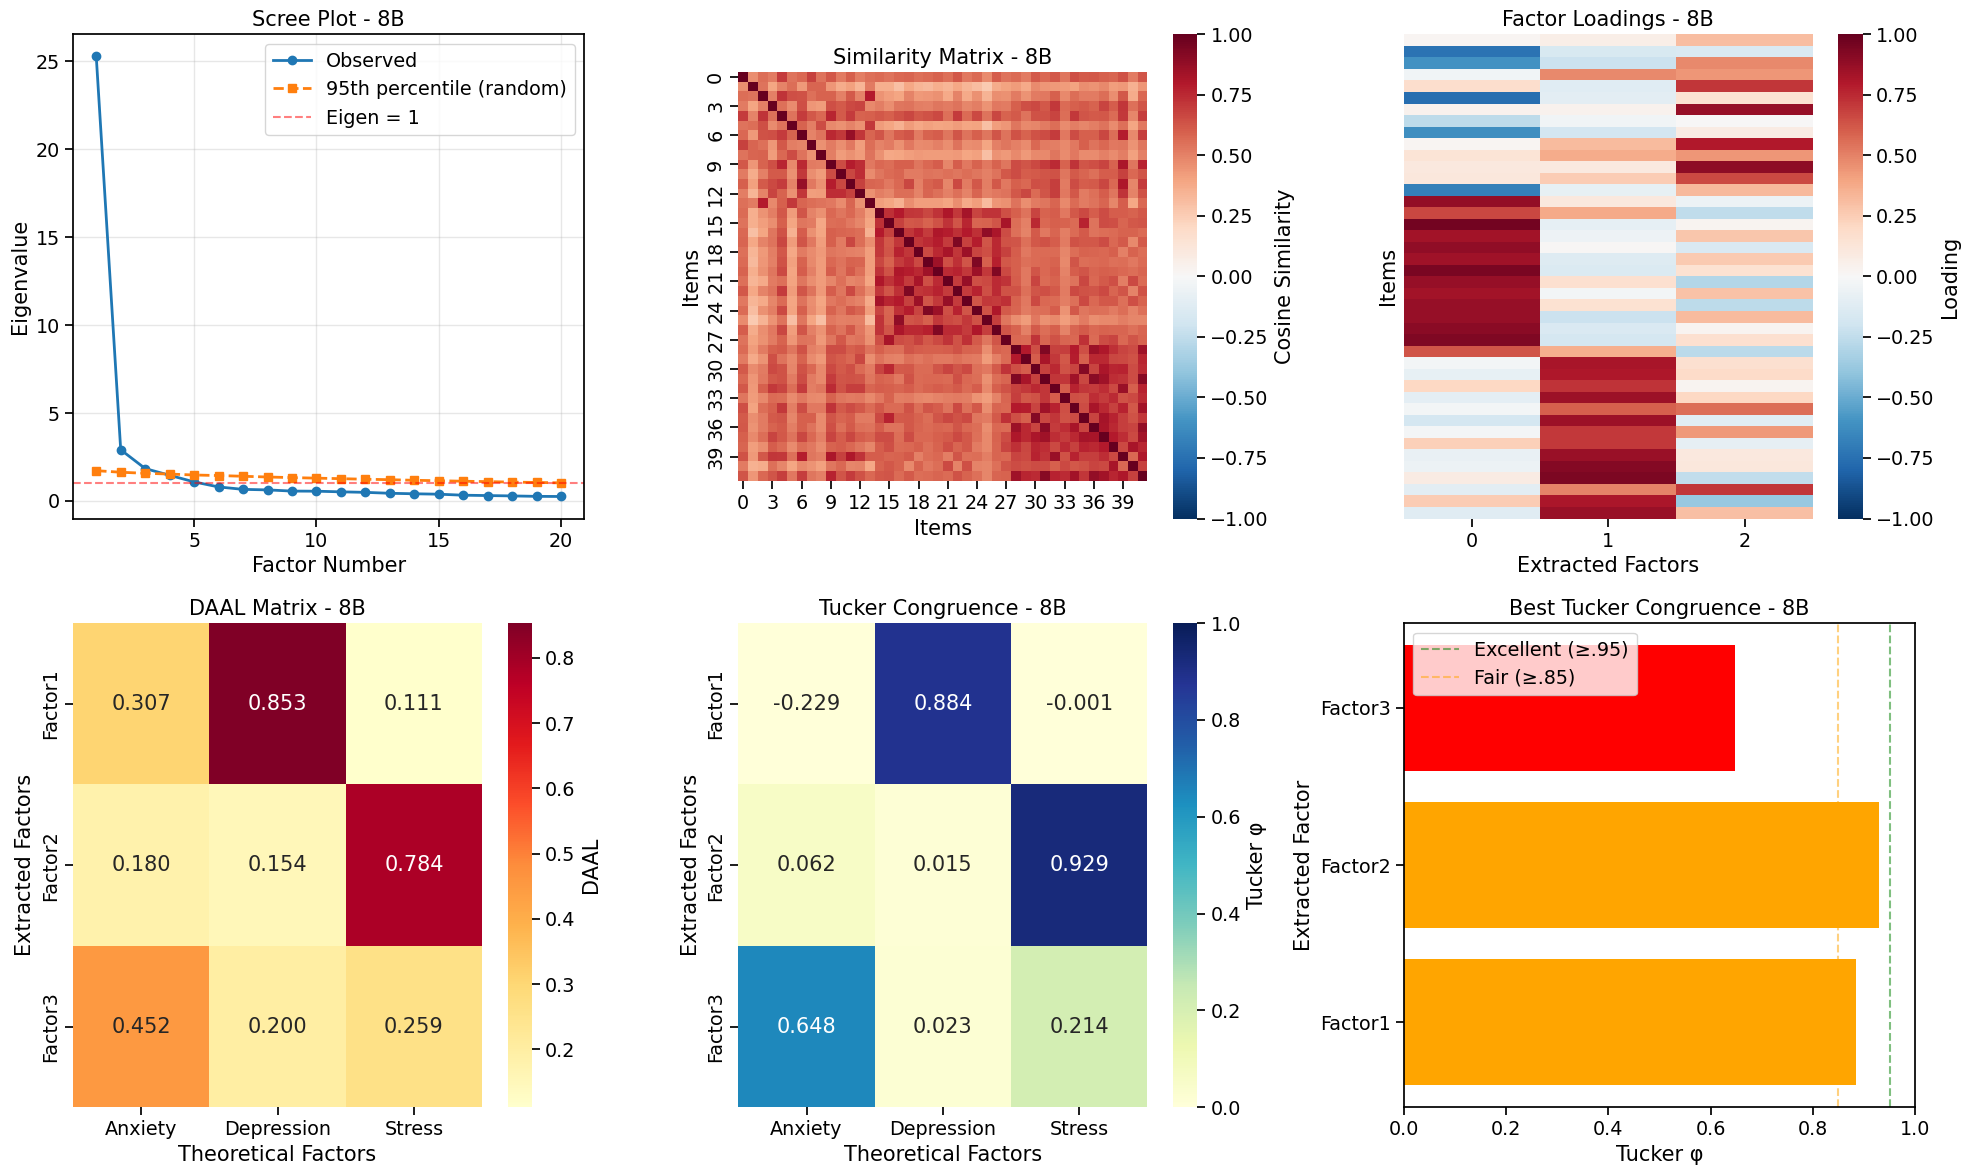

In [62]:
all_results = {}

for model_size in model_sizes:
    embeddings = all_embeddings[model_size]
    
    results = run_pfa_for_model(
        model_size=model_size,
        embeddings=embeddings,
        codes=codes,
        items=items,
        factors=factors,
        scoring=scoring,
        n_factors=N_FACTORS,
        rotation=ROTATION_METHOD,
        extraction_method=EXTRACTION_METHOD,
        eigen_criteria=EIGEN_CRITERIA,
        parallel_iter=PARALLEL_ITER,
        random_state=RANDOM_STATE,
        save_dir=SAVE_DIR
    )
    
    all_results[model_size] = results
    
    # DEBUG: Check eigenvalues immediately after PFA
#     print(f"DEBUG: {model_size} eigenvalues after PFA: {results['observed_eigenvalues'][:3]}") # Suppressed from log
#     print(f"DEBUG: Matrix used has [0,1]={results['similarity_matrix'][0,1]:.6f}") # Suppressed from log
    
    # Create visualizations
    create_visualizations(results, factors, codes, model_size, save_dir=SAVE_DIR)


In [63]:
# Robust patching to prevent recursion
import numpy as np
import pandas as pd
import factor_analyzer.factor_analyzer as fa
import importlib

# Ensure we have the original function
if not hasattr(fa, '_original_calculate_kmo'):
    # Reload to get clean state if needed
    importlib.reload(fa)
    fa._original_calculate_kmo = fa.calculate_kmo
    fa._original_calculate_bartlett = fa.calculate_bartlett_sphericity
    print("Loaded and saved original factor_analyzer functions.")
else:
    print("Using previously saved original factor_analyzer functions.")

def regularize_correlation_matrix(corr_matrix, alpha=1e-6):
    """Add regularization to correlation matrix."""
    is_df = isinstance(corr_matrix, pd.DataFrame)
    corr_array = corr_matrix.values.copy() if is_df else corr_matrix.copy()
    
    n = corr_array.shape[0]
    regularized = corr_array + alpha * np.eye(n)
    diag = np.sqrt(np.diag(regularized))
    regularized = regularized / diag[:, None] / diag[None, :]
    
    if is_df:
        return pd.DataFrame(regularized, index=corr_matrix.index, columns=corr_matrix.columns)
    return regularized

def safe_calculate_kmo(corr_matrix, alpha=1e-6):
    """KMO with auto-regularization."""
    try:
        return fa._original_calculate_kmo(corr_matrix)
    except (np.linalg.LinAlgError, AssertionError):
        print(f"  ⚠️  Singular matrix detected, applying regularization (alpha={alpha})...")
        return fa._original_calculate_kmo(regularize_correlation_matrix(corr_matrix, alpha))

def safe_calculate_bartlett(corr_matrix, alpha=1e-6):
    """Bartlett with auto-regularization."""
    try:
        return fa._original_calculate_bartlett(corr_matrix)
    except (np.linalg.LinAlgError, AssertionError):
        print(f"  ⚠️  Singular matrix detected, applying regularization (alpha={alpha})...")
        return fa._original_calculate_bartlett(regularize_correlation_matrix(corr_matrix, alpha))

# Clean data - remove missing values (handle both DataFrame and ndarray)
print(f"\n{'='*70}")
print("PREPROCESSING EMPIRICAL DATA")
print(f"{'='*70}")

if isinstance(empirical_data, pd.DataFrame):
    print(f"Original shape: {empirical_data.shape}")
    n_before = len(empirical_data)
    empirical_data = empirical_data.dropna()
    n_after = len(empirical_data)
    if n_before - n_after > 0:
        print(f"Removed {n_before - n_after} rows with missing values ({(n_before - n_after)/n_before*100:.1f}%)")
    else:
        print("No missing values found")
    print(f"Final shape: {empirical_data.shape}")
elif isinstance(empirical_data, np.ndarray):
    print(f"Original shape: {empirical_data.shape}")
    # For numpy arrays, remove rows with any NaN values
    mask = ~np.isnan(empirical_data).any(axis=1)
    n_before = len(empirical_data)
    empirical_data = empirical_data[mask]
    n_after = len(empirical_data)
    if n_before - n_after > 0:
        print(f"Removed {n_before - n_after} rows with missing values ({(n_before - n_after)/n_before*100:.1f}%)")
    else:
        print("No missing values found")
    print(f"Final shape: {empirical_data.shape}")
else:
    print(f"Data type: {type(empirical_data)}")
    print("Warning: Could not clean data (unexpected type)")

print(f"{'='*70}\n")

# Patch functions globally
fa.calculate_kmo = safe_calculate_kmo
fa.calculate_bartlett_sphericity = safe_calculate_bartlett

print("✓ Installed safe KMO and Bartlett calculation functions (Recursion-proof)")
print("✓ These will automatically handle singular matrices with regularization\n")


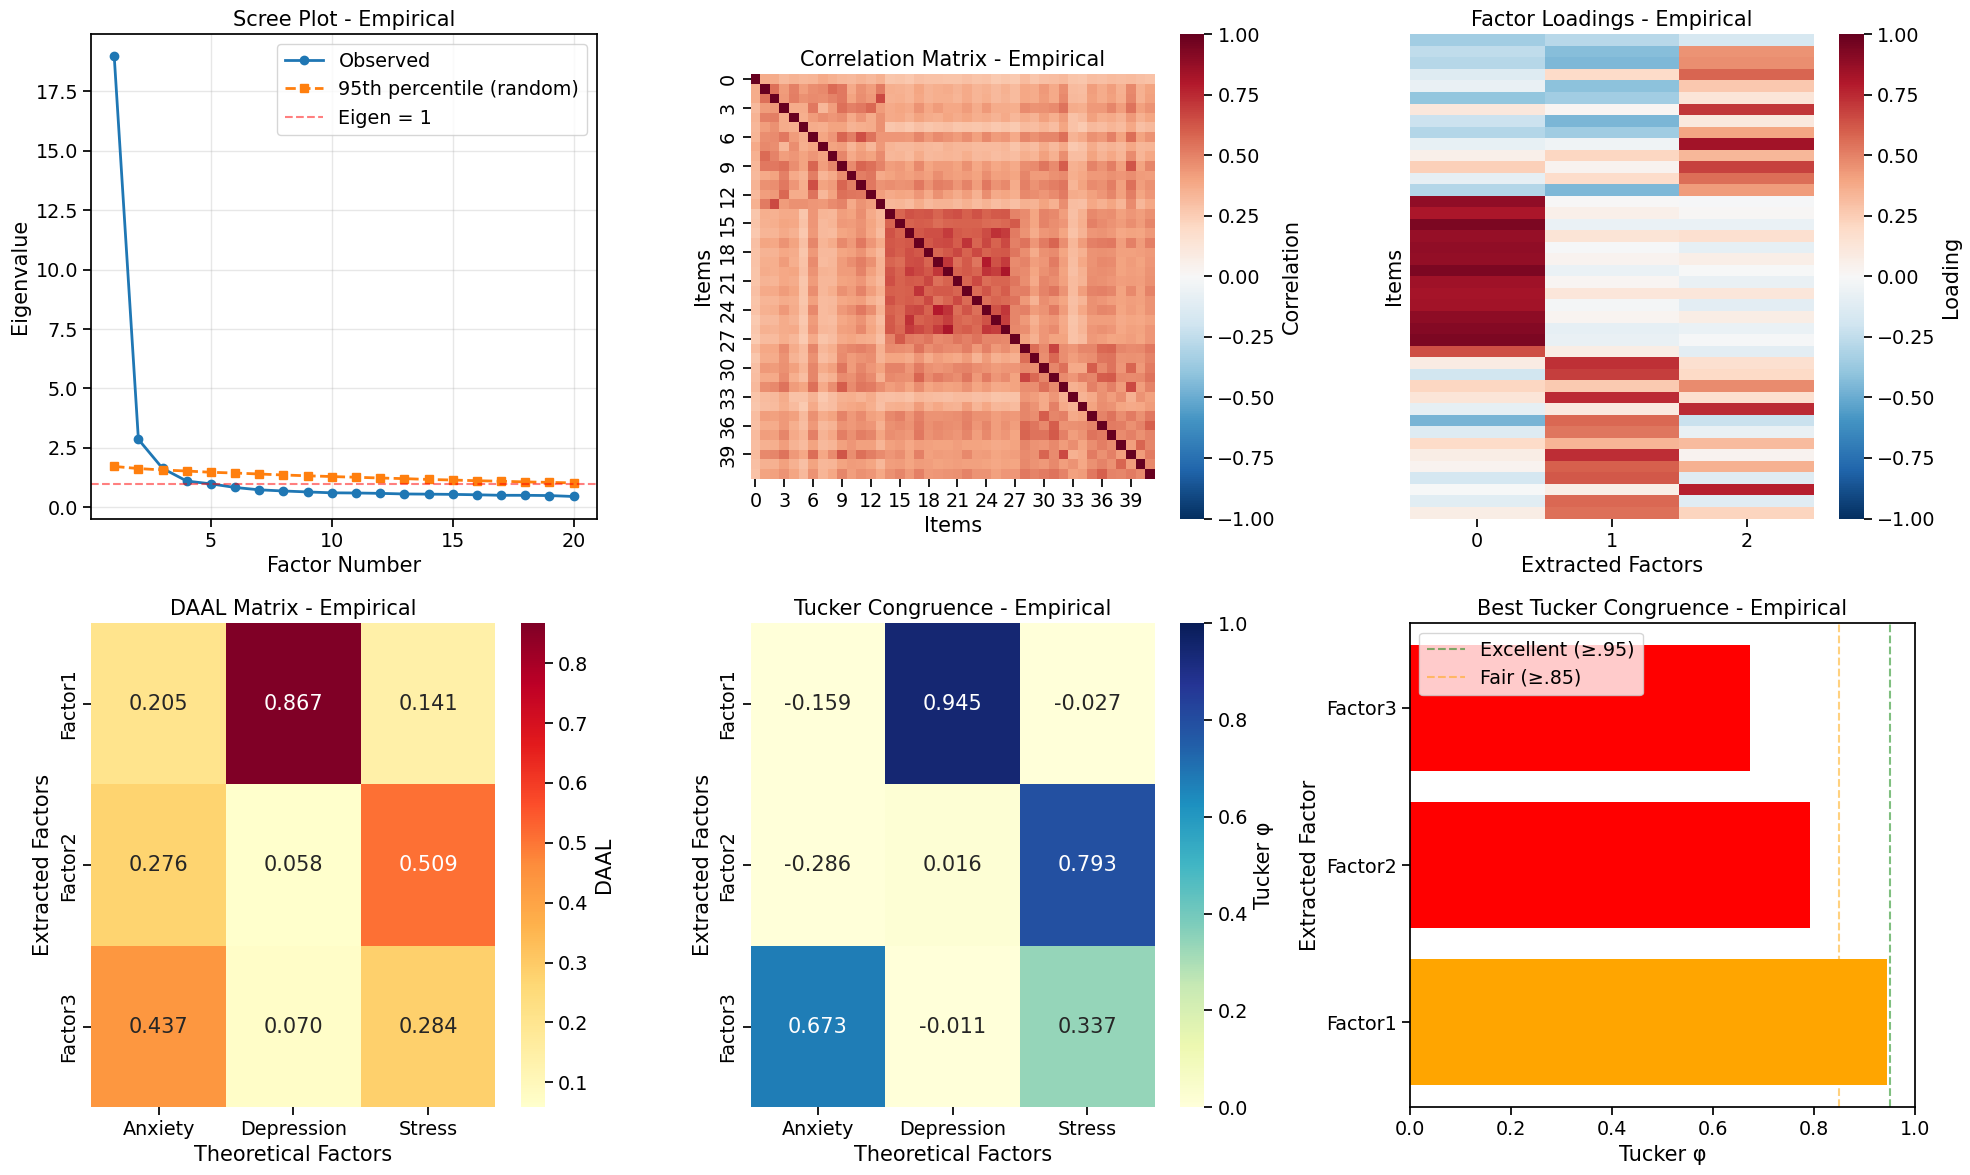

In [64]:
# ==============================================================================
# Run Traditional EFA on Empirical Data
# ==============================================================================

empirical_results = None

if empirical_data is not None:
    print(f"\n{'='*70}")
    print("RUNNING TRADITIONAL EFA ON EMPIRICAL DATA")
    print(f"{'='*70}")
    
    empirical_results = run_efa_on_data(
        data_label="Empirical",
        response_data=empirical_data,
        codes=codes,
        items=items,
        factors=factors,
        scoring=scoring,
        n_factors=N_FACTORS,
        rotation=ROTATION_METHOD,
        extraction_method=EXTRACTION_METHOD,
        eigen_criteria=EIGEN_CRITERIA,
        parallel_iter=PARALLEL_ITER,
        random_state=RANDOM_STATE,
        save_dir=SAVE_DIR
    )
    
    # Create visualizations for empirical data
    create_visualizations(empirical_results, factors, codes, "Empirical", 
                         save_dir=SAVE_DIR, data_type='empirical')
    
    print(f"\n✓ TRADITIONAL EFA COMPLETE")
else:
    print(f"\n{'='*70}")
    print("Empirical data not loaded - skipping traditional EFA")
    print(f"{'='*70}")

# DEBUG: Check if all_results eigenvalues corrupted after empirical EFA
print(f"DEBUG AFTER EMPIRICAL: 8B eigenvalues = {all_results['8B']['observed_eigenvalues'][:3]}")
if empirical_results is not None:
    print(f"DEBUG AFTER EMPIRICAL: Empirical eigenvalues = {empirical_results['observed_eigenvalues'][:3]}")
else:
    print(f"DEBUG AFTER EMPIRICAL: Empirical results = None (data not loaded or error occurred)")

## Analyze Nearest Neighbors - All Models

Examine nearest neighbors in the original high-dimensional embedding space to validate semantic clustering.

In [65]:
# Select a sample item to analyze
sample_idx = 0  # First item

print("Finding nearest neighbors in original embedding space...")
print(f"\nSample item #{sample_idx}:")
print(f"  Code: {codes[sample_idx]}")
print(f"  Factor: {factors[sample_idx]}")
print(f"  Text: {items[sample_idx]}")

for model_size in model_sizes:
    embeddings = all_embeddings[model_size]
    print(f"{model_size} Model - Original {embeddings.shape[1]}D Space")
    
    # Compute cosine similarity between sample and all items
    # Note: embeddings are already processed through atomic-reversed encoding
    # For pure nearest neighbors, we could use original embeddings, but using
    # the processed ones ensures consistency with the PFA analysis
    similarities = cosine_similarity([embeddings[sample_idx]], embeddings)[0]
    
    # Find 5 most similar items (excluding itself)
    most_similar_indices = np.argsort(similarities)[::-1][1:6]
    
    print(f"5 Most similar items (by cosine similarity):")
    for rank, idx in enumerate(most_similar_indices, 1):
        print(f"  {rank}. [{factors[idx]}] {items[idx][:80]}...")
        print(f"      Similarity: {similarities[idx]:.4f}")

print("✓ Nearest neighbors analysis complete")

## Within- vs Between-Construct Similarity Analysis (Milano et al. 2025)

Test whether items from the same theoretical factor are more similar than items from different factors.

**Method:**
- **Within-construct similarities**: Cosine similarities between items sharing the same factor
- **Between-construct similarities**: Cosine similarities between items from different factors
- **Statistical test**: Welch's t-test (unequal variances)
- **Effect size**: Cohen's d

This analysis provides empirical evidence for **construct validity**: if embeddings capture the theoretical factor structure, within-construct similarities should be significantly higher than between-construct similarities.

In [66]:
print("Factor Separation Analysis:")

from scipy.stats import ttest_ind

for model_size in model_sizes:
    print(f"\n{model_size} Model:")
    
    # Get similarity matrix from results
    sim_matrix = all_results[model_size]['similarity_matrix']
    n_items = len(factors)
    
    # Collect similarities (upper triangle only, i < j)
    within_sims = []
    between_sims = []
    
    for i in range(n_items):
        for j in range(i + 1, n_items):  # Upper triangle only
            sim = sim_matrix[i, j]
            
            if factors[i] == factors[j]:
                within_sims.append(sim)
            else:
                between_sims.append(sim)
    
    # Convert to arrays
    within_sims = np.array(within_sims)
    between_sims = np.array(between_sims)
    
    # Compute statistics
    mean_within = np.mean(within_sims)
    sd_within = np.std(within_sims, ddof=1)
    mean_between = np.mean(between_sims)
    sd_between = np.std(between_sims, ddof=1)
    mean_diff = mean_within - mean_between
    
    # Cohen's d (pooled standard deviation)
    pooled_sd = np.sqrt((sd_within**2 + sd_between**2) / 2)
    cohens_d = mean_diff / pooled_sd if pooled_sd > 0 else 0.0
    
    # Welch's t-test (unequal variances)
    t_stat, p_value = ttest_ind(within_sims, between_sims, equal_var=False)
    
    # Degrees of freedom (Welch-Satterthwaite)
    n1, n2 = len(within_sims), len(between_sims)
    s1_sq, s2_sq = sd_within**2, sd_between**2
    df = (s1_sq/n1 + s2_sq/n2)**2 / ((s1_sq/n1)**2/(n1-1) + (s2_sq/n2)**2/(n2-1))
    
    # Print results
    print(f"  Within-construct:  M = {mean_within:.3f}, SD = {sd_within:.3f}, n = {len(within_sims)}")
    print(f"  Between-construct: M = {mean_between:.3f}, SD = {sd_between:.3f}, n = {len(between_sims)}")
    print(f"  Mean difference: {mean_diff:.3f}")
    print(f"  Welch's t({df:.1f}) = {t_stat:.2f}, p = {p_value:.4e}")
    print(f"  Cohen's d = {cohens_d:.3f}")
    
    # Interpretation
    if p_value < 0.001:
        sig_text = "highly significant (p < .001)"
    elif p_value < 0.01:
        sig_text = "very significant (p < .01)"
    elif p_value < 0.05:
        sig_text = "significant (p < .05)"
    else:
        sig_text = "not significant (p ≥ .05)"
    
    if abs(cohens_d) >= 0.8:
        effect_text = "large effect"
    elif abs(cohens_d) >= 0.5:
        effect_text = "medium effect"
    elif abs(cohens_d) >= 0.2:
        effect_text = "small effect"
    else:
        effect_text = "negligible effect"
    
    print(f"\n  Interpretation: {sig_text}, {effect_text}")
    
    if mean_within > mean_between and p_value < 0.05:
        print(f"  ✓ Items from the same factor are significantly more similar.")
    elif mean_within < mean_between and p_value < 0.05:
        print(f"  ⚠ Items from different factors are MORE similar (unexpected!).")
    else:
        print(f"  ⚠ No significant difference in within- vs between-construct similarity.")

print("✓ Factor Separation Analysis Complete")

In [67]:
print("FACTOR SEPARATION ANALYSIS")
print("=" * 70)

for model_size in model_sizes:
    print(f"\n{'='*70}")
    print(f"{model_size} Model - Factor Separation Metrics")
    print(f"{'='*70}")
    
    # Use PFA similarity matrix (atomic-reversed encoded)
    sim_matrix = all_results[model_size]['similarity_matrix']
    
    # Initialize accumulators
    unique_factors = sorted(set(factors))
    within_factor_sims = {factor: [] for factor in unique_factors}
    between_factor_sims = []
    
    # Compute within-factor and between-factor similarities
    for i in range(len(factors)):
        for j in range(i + 1, len(factors)):
            similarity = sim_matrix[i, j]
            
            if factors[i] == factors[j]:
                within_factor_sims[factors[i]].append(similarity)
            else:
                between_factor_sims.append(similarity)
    
    # Compute overall metrics
    all_within_sims = []
    for factor_sims in within_factor_sims.values():
        all_within_sims.extend(factor_sims)
    
    within_mean = np.mean(all_within_sims)
    between_mean = np.mean(between_factor_sims)
    separation_ratio = within_mean / between_mean
    
    # Print overall results
    print(f"\nOverall Separation Metrics:")
    print(f"  Within-factor similarity:  {within_mean:.4f}")
    print(f"  Between-factor similarity: {between_mean:.4f}")
    print(f"  Separation ratio:          {separation_ratio:.4f}")
    print(f"    {'(Good separation - factors cluster together!)' if separation_ratio > 1.0 else '(Poor separation - factors overlap)'}")
    
    # Print per-factor breakdown
    print(f"\nPer-Factor Within-Similarity:")
    for factor in unique_factors:
        if len(within_factor_sims[factor]) > 0:
            factor_mean = np.mean(within_factor_sims[factor])
            factor_std = np.std(within_factor_sims[factor], ddof=1)
            n_pairs = len(within_factor_sims[factor])
            print(f"  {factor:12s}: {factor_mean:.4f} ± {factor_std:.4f}  (n={n_pairs} pairs)")
    
    # Compute pairwise between-factor similarities
    print(f"\nBetween-Factor Similarities:")
    factor_pairs = {}
    for i in range(len(factors)):
        for j in range(i + 1, len(factors)):
            if factors[i] != factors[j]:
                pair = tuple(sorted([factors[i], factors[j]]))
                if pair not in factor_pairs:
                    factor_pairs[pair] = []
                factor_pairs[pair].append(sim_matrix[i, j])
    
    for pair in sorted(factor_pairs.keys()):
        pair_mean = np.mean(factor_pairs[pair])
        pair_std = np.std(factor_pairs[pair], ddof=1)
        n_pairs = len(factor_pairs[pair])
        print(f"  {pair[0]:12s} vs {pair[1]:12s}: {pair_mean:.4f} ± {pair_std:.4f}  (n={n_pairs} pairs)")


# Empirical Data Analysis
if 'empirical_results' in globals() and empirical_results is not None:
    print(f"\n{'='*70}")
    print(f"Empirical Data - Factor Separation Metrics")
    print(f"{'='*70}")
    
    # Use correlation matrix from empirical results
    corr_matrix = empirical_results['similarity_matrix']
    
    # Initialize accumulators
    unique_factors = sorted(set(factors))
    within_factor_corrs = {factor: [] for factor in unique_factors}
    between_factor_corrs = []
    
    # Compute within-factor and between-factor correlations
    for i in range(len(factors)):
        for j in range(i + 1, len(factors)):
            correlation = corr_matrix[i, j]
            
            if factors[i] == factors[j]:
                within_factor_corrs[factors[i]].append(correlation)
            else:
                between_factor_corrs.append(correlation)
    
    # Compute overall metrics
    all_within_corrs = []
    for factor_corrs in within_factor_corrs.values():
        all_within_corrs.extend(factor_corrs)
    
    within_mean = np.mean(all_within_corrs)
    between_mean = np.mean(between_factor_corrs)
    separation_ratio = within_mean / between_mean
    
    # Print overall results
    print(f"\nOverall Separation Metrics:")
    print(f"  Within-factor correlation:  {within_mean:.4f}")
    print(f"  Between-factor correlation: {between_mean:.4f}")
    print(f"  Separation ratio:           {separation_ratio:.4f}")
    print(f"    {'(Good separation - factors cluster together!)' if separation_ratio > 1.0 else '(Poor separation - factors overlap)'}")
    
    # Print per-factor breakdown
    print(f"\nPer-Factor Within-Correlation:")
    for factor in unique_factors:
        if len(within_factor_corrs[factor]) > 0:
            factor_mean = np.mean(within_factor_corrs[factor])
            factor_std = np.std(within_factor_corrs[factor], ddof=1)
            n_pairs = len(within_factor_corrs[factor])
            print(f"  {factor:12s}: {factor_mean:.4f} ± {factor_std:.4f}  (n={n_pairs} pairs)")
    
    # Compute pairwise between-factor correlations
    print(f"\nBetween-Factor Correlations:")
    factor_pairs = {}
    for i in range(len(factors)):
        for j in range(i + 1, len(factors)):
            if factors[i] != factors[j]:
                pair = tuple(sorted([factors[i], factors[j]]))
                if pair not in factor_pairs:
                    factor_pairs[pair] = []
                factor_pairs[pair].append(corr_matrix[i, j])
    
    for pair in sorted(factor_pairs.keys()):
        pair_mean = np.mean(factor_pairs[pair])
        pair_std = np.std(factor_pairs[pair], ddof=1)
        n_pairs = len(factor_pairs[pair])
        print(f"  {pair[0]:12s} vs {pair[1]:12s}: {pair_mean:.4f} ± {pair_std:.4f}  (n={n_pairs} pairs)")
else:
    print(f"\n{'='*70}")
    print("Empirical results not available - skipping empirical factor separation analysis")
    print(f"{'='*70}")

print(f"\n{'='*70}")
print("✓ Factor separation analysis complete!")
print(f"{'='*70}")

## Summary Report

Display key diagnostics and results for all models.

In [68]:
print("SUMMARY")

for model_size in model_sizes:
    results = all_results[model_size]
    print(f"\n{model_size}:")
    
    if 'diagnostics' in results:
        diag = results['diagnostics'].iloc[0]
        print(f"  Items: {diag['n_items']}")
        print(f"  Factors: {diag['n_factors_extracted']}")
        print(f"  Rotation: {diag['rotation']}")
        if 'kmo' in diag:
            print(f"  KMO: {diag['kmo']:.3f}")
        if 'bartlett_p' in diag:
            print(f"  Bartlett p: {diag['bartlett_p']:.4e}")
        print(f"  Variance: {diag['variance_explained']:.1%}")
    
    if 'daal_assignments' in results:
        print("\n  DAAL assignments:")
        for _, row in results['daal_assignments'].iterrows():
            print(f"    {row['extracted_factor']} → {row['assigned_to']} (DAAL={row['daal']:.3f})")
    
    if 'tucker_best' in results:
        print("\n  Tucker congruence:")
        for _, row in results['tucker_best'].iterrows():
            print(f"    {row['extracted_factor']} ↔ {row['best_match']} (φ={row['tucker_phi']:.3f})")

print(f"\nResults saved to: {SAVE_DIR}/")

## Automatic Factor Naming with LLM

Generate semantic names for EFA-extracted factors using Qwen2.5-1.5B-Instruct.

**Approach:**
1. For each extracted factor, identify the top 10 items with highest absolute loadings
2. Extract the text of these high-loading items
3. Feed the item text to Qwen2.5-1.5B-Instruct LLM with a prompt
4. LLM generates a concise semantic label (single word or short phrase) describing what the items measure
5. Store factor name mappings in `factor_name_mappings` dictionary

**Prompt Format:**
```
"These are items from a psychological scale that all load strongly on the same latent factor: [item1 | item2 | ...]. 
Provide a single word or very short phrase that best describes the psychological construct these items are measuring."
```

**Advantages over vocabulary-based naming:**
- Uses actual scale items that define each factor (not external vocabulary)
- More psychologically valid (factors are defined by their indicators)
- No need to load separate word embeddings
- Direct relationship between loadings and names

**Note:** Generated names are stored in the `factor_name_mappings` dictionary. Original results in `all_results` remain unchanged.

In [69]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

print("Loading word list for nearest neighbor factor naming...")

# Path to word list (used only if generating embeddings)
word_list_path = "word_lists/constructs.csv"

# Check if any model has pregenerated embeddings specified
has_pregenerated = any(model_size in PREGENERATED_WORD_EMBEDDINGS for model_size in [m.split('-')[-1] for m in MODEL_NAMES])

# If pregenerated embeddings exist, load words from there instead of CSV
if has_pregenerated:
    # Get first pregenerated path to extract word list
    first_model_size = [m.split('-')[-1] for m in MODEL_NAMES][0]
    if first_model_size in PREGENERATED_WORD_EMBEDDINGS:
        pregenerated_path = PREGENERATED_WORD_EMBEDDINGS[first_model_size]
        if os.path.exists(pregenerated_path):
            print(f"Loading words from pregenerated embeddings: {pregenerated_path}")
            try:
                data = np.load(pregenerated_path, allow_pickle=True)
                if 'words' in data:
                    words = data['words'].tolist()
                    print(f"✓ Loaded {len(words)} words from pregenerated embeddings")
                else:
                    print(f"✗ 'words' key not found in {pregenerated_path}")
                    print(f"  Available keys: {list(data.keys())}")
                    print(f"  Falling back to {word_list_path}")
                    words_df = pd.read_csv(word_list_path, header=None, names=['word'])
                    words = words_df['word'].tolist()
                    print(f"✓ Loaded {len(words)} words from {word_list_path}")
            except Exception as e:
                print(f"✗ Error loading words from pregenerated: {e}")
                print(f"  Falling back to {word_list_path}")
                words_df = pd.read_csv(word_list_path, header=None, names=['word'])
                words = words_df['word'].tolist()
                print(f"✓ Loaded {len(words)} words from {word_list_path}")
        else:
            print(f"✗ Pregenerated path not found: {pregenerated_path}")
            print(f"  Loading from {word_list_path}")
            words_df = pd.read_csv(word_list_path, header=None, names=['word'])
            words = words_df['word'].tolist()
            print(f"✓ Loaded {len(words)} words from {word_list_path}")
    else:
        # Load from CSV
        try:
            words_df = pd.read_csv(word_list_path, header=None, names=['word'])
            words = words_df['word'].tolist()
            print(f"✓ Loaded {len(words)} words from {word_list_path}")
        except Exception as e:
            print(f"✗ Error loading word list: {e}")
            print("  Nearest neighbor method will be skipped.")
            words = None
else:
    # No pregenerated embeddings - load words from CSV
    try:
        words_df = pd.read_csv(word_list_path, header=None, names=['word'])
        words = words_df['word'].tolist()
        print(f"✓ Loaded {len(words)} words from {word_list_path}")
    except Exception as e:
        print(f"✗ Error loading word list: {e}")
        print("  Nearest neighbor method will be skipped.")
        words = None

# Generate/load embeddings for words
if words is not None:
    all_word_embeddings = {}
    
    for model_size in model_sizes:
        print(f"\n{model_size} Model - Word Embeddings:")
        
        # Check if pregenerated embeddings are specified for this model
        if model_size in PREGENERATED_WORD_EMBEDDINGS:
            word_emb_path = PREGENERATED_WORD_EMBEDDINGS[model_size]
            if os.path.exists(word_emb_path):
                print(f"  Loading pregenerated from {word_emb_path}...")
                try:
                    data = np.load(word_emb_path, allow_pickle=True)
                    
                    # Try different possible key names for embeddings
                    word_embeddings = None
                    for key in ['word_embeddings', 'embeddings', 'vectors', 'arr_0']:
                        if key in data:
                            word_embeddings = data[key]
                            print(f"  ✓ Loaded from key '{key}': {word_embeddings.shape}")
                            break
                    
                    if word_embeddings is None:
                        print(f"  ✗ Could not find embeddings in file")
                        print(f"  Available keys: {list(data.keys())}")
                        print(f"  Falling back to generation...")
                        word_embeddings = None
                    else:
                        # Verify shape matches word count
                        if word_embeddings.shape[0] != len(words):
                            print(f"  ⚠ WARNING: Embedding count ({word_embeddings.shape[0]}) != word count ({len(words)})")
                        
                        all_word_embeddings[model_size] = word_embeddings
                        continue
                        
                except Exception as e:
                    print(f"  ✗ Error loading pregenerated embeddings: {e}")
                    print(f"  Falling back to generation...")
            else:
                print(f"  ⚠ Pregenerated path specified but not found: {word_emb_path}")
                print(f"  Falling back to generation...")
        
        # No pregenerated path or file doesn't exist - check cache then generate
        word_emb_path = f"embeddings/word_embeddings_{model_size}.npz"
        
        if os.path.exists(word_emb_path):
            print(f"  Loading from cache: {word_emb_path}...")
            data = np.load(word_emb_path, allow_pickle=True)
            word_embeddings = data['word_embeddings']
            print(f"  ✓ Loaded: {word_embeddings.shape}")
        else:
            # Generate embeddings using the same model
            print(f"  Generating embeddings for {len(words)} words...")
            
            # Get the model (already loaded earlier)
            model_cache_name = MODEL_NAMES[model_sizes.index(model_size)].replace('/', '--')
            snapshots_dir = f"/Users/devon7y/.cache/huggingface/models--{model_cache_name}/snapshots"
            snapshot_dirs = glob.glob(f"{snapshots_dir}/*")
            
            if snapshot_dirs:
                snapshot_path = snapshot_dirs[0]
                model = SentenceTransformer(snapshot_path, device=device)
                
                # Encode words in batches
                word_embeddings = model.encode(
                    words, 
                    show_progress_bar=True, 
                    batch_size=256,
                    convert_to_numpy=True, 
                    normalize_embeddings=False
                )
                
                print(f"  ✓ Generated: {word_embeddings.shape}")
                
                # Save for future use
                np.savez(word_emb_path, word_embeddings=word_embeddings, words=words)
                print(f"  ✓ Saved to {word_emb_path}")
            else:
                print(f"  ✗ Could not find model snapshots")
                word_embeddings = None
        
        all_word_embeddings[model_size] = word_embeddings
    
    print(f"\n✓ Word embeddings ready for {len(all_word_embeddings)} model(s)")
else:
    all_word_embeddings = {}
    print("\n⚠ Word embeddings not available - nearest neighbor method will be skipped")

In [70]:
import os
from openai import OpenAI
import re
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import math

# Check if factor naming is enabled
if not ENABLE_FACTOR_NAMING:
    print("\n" + "="*70)
    print("FACTOR NAMING DISABLED")
    print("="*70)
    print("  Set ENABLE_FACTOR_NAMING = True to enable automatic factor naming")
    print("="*70 + "\n")
else:
    print("Setting up HuggingFace API client for automatic factor naming...")

    # Check if HF_TOKEN is set
    if "HF_TOKEN" not in os.environ:
        print("\n✗ Error: HF_TOKEN environment variable not set!")
        print("  Please set your HuggingFace token in the environment.")
        print("\nSkipping automatic factor naming...")
        client = None
    else:
        # Initialize OpenAI-compatible HF client
        client = OpenAI(
            base_url="https://router.huggingface.co/v1",
            api_key=os.environ["HF_TOKEN"],
        )
        print("✓ HuggingFace API client initialized")
        print(f"  Instruct model: Qwen/Qwen3-235B-A22B-Instruct-2507:novita")
        print(f"  Base model: Qwen/Qwen3-235B-A22B:novita")

    # Only proceed if client is available
    if client is not None:
        print(f"\n{'='*70}")
        print("COMPARING THREE FACTOR NAMING APPROACHES")
        print(f"{'='*70}")
        print("\nMethod 1: Direct Scale Items (with psychological context)")
        print("Method 2: Nearest Neighbor Words (vocabulary-based, instruction-tuned)")
        print("Method 3: Base Model Token Prediction (non-instruct, greedy sampling)")
        print(f"{'='*70}\n")

        # Store factor name mappings for all three methods
        factor_name_mappings_direct = {}
        factor_name_mappings_nn = {}
        factor_name_mappings_base = {}

        factor_probabilities_base = {}

        # Check if word embeddings are available
        nn_available = 'all_word_embeddings' in dir() and len(all_word_embeddings) > 0 and 'words' in dir() and words is not None

        # Process each model
        for model_size in model_sizes:
            print(f"\n{'='*70}")
            print(f"{model_size} Model - Automatic Factor Naming")
            print(f"{'='*70}")

            # Load factor loadings and embeddings
            loadings_df = all_results[model_size]['loadings']
            embeddings = all_embeddings[model_size]

            factor_name_mappings_direct[model_size] = {}
            factor_name_mappings_nn[model_size] = {}
            factor_name_mappings_base[model_size] = {}
            factor_probabilities_base[model_size] = {}

            if nn_available:
                word_embeddings = all_word_embeddings[model_size]
                print(f"\n✓ Word embeddings available: {word_embeddings.shape}")
            else:
                print(f"\n⚠ Word embeddings not available - only Method 1 will run")

            # Process each factor
            for factor_name in loadings_df.columns:
                print(f"\n{'='*70}")
                print(f"{factor_name}:")
                print(f"{'='*70}")

                # Top 10 items by absolute loading
                factor_loadings = loadings_df[factor_name].abs()
                top_indices = factor_loadings.nlargest(10).index

                # ===== METHOD 1: DIRECT SCALE ITEMS =====
                print(f"\n[METHOD 1: Direct Scale Items]")
                top_items_text = []
                print(f"Top 10 loading items:")
                for i, code in enumerate(top_indices, 1):
                    item_idx = codes.index(code)
                    item_text = items[item_idx]
                    loading_val = loadings_df.loc[code, factor_name]
                    top_items_text.append(item_text)
                    print(f"  {i}. (λ={loading_val:.3f}): {item_text[:70]}")

                # Prepare prompt
                items_for_prompt = " | ".join([item[:120] for item in top_items_text])
                user_prompt_direct = f"These are items from a psychological scale that all load strongly on the same latent factor: {items_for_prompt} Provide a single word or very short phrase (max 3 words) that best describes the psychological construct. Provide ONLY the label."

                system_prompt = "You are a helpful assistant that provides concise, one or two-word summaries."

                # API call
                completion = client.chat.completions.create(
                    model="Qwen/Qwen3-235B-A22B-Instruct-2507:novita",
                    messages=[
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": user_prompt_direct}
                    ],
                    max_tokens=10,
                    temperature=0,
                    seed=42,
                )

                # Clean result
                generated_name_direct = completion.choices[0].message.content.strip()
                generated_name_direct = re.sub(r'^["\'\s]+|["\'\s]+$', '', generated_name_direct)
                generated_name_direct = re.sub(r'[.,;:!?]+$', '', generated_name_direct)
                generated_name_direct = generated_name_direct.split('\n')[0].strip()
                generated_name_direct = re.sub(r'^\*+|\*+$', '', generated_name_direct)
                if len(generated_name_direct) < 2:
                    generated_name_direct = factor_name

                factor_name_mappings_direct[model_size][factor_name] = generated_name_direct
                print(f"  Method 1 Result: '{generated_name_direct}'")

                # ===== METHOD 2: NEAREST NEIGHBOR (INSTRUCT-TUNED) =====
                if nn_available:
                    print(f"\n[METHOD 2: Nearest Neighbor Words]")
                    top_item_indices = [codes.index(code) for code in top_indices]
                    factor_embeddings = embeddings[top_item_indices]
                    factor_embeddings_norm = factor_embeddings / np.linalg.norm(factor_embeddings, axis=1, keepdims=True)
                    centroid = np.mean(factor_embeddings_norm, axis=0)
                    centroid_norm = centroid / np.linalg.norm(centroid)

                    similarities = cosine_similarity([centroid_norm], word_embeddings)[0]
                    top_word_indices = np.argsort(similarities)[::-1][:10]
                    top_words = [words[idx] for idx in top_word_indices]

                    print("Top 10 nearest neighbor words:")
                    for i, (word_idx, word) in enumerate(zip(top_word_indices, top_words), 1):
                        print(f"  {i}. {word:<20} (sim={similarities[word_idx]:.4f})")

                    words_list = ", ".join(top_words)
                    user_prompt_nn = f"Give a label that best summarizes these related concepts: {words_list}. Provide ONLY the label."

                    completion = client.chat.completions.create(
                        model="Qwen/Qwen3-235B-A22B-Instruct-2507:novita",
                        messages=[
                            {"role": "system", "content": system_prompt},
                            {"role": "user", "content": user_prompt_nn}
                        ],
                        max_tokens=10,
                        temperature=0,
                        seed=42,
                    )

                    generated_name_nn = completion.choices[0].message.content.strip()
                    generated_name_nn = re.sub(r'^["\'\s]+|["\'\s]+$', '', generated_name_nn)
                    generated_name_nn = re.sub(r'[.,;:!?]+$', '', generated_name_nn)
                    generated_name_nn = generated_name_nn.split('\n')[0].strip()
                    if len(generated_name_nn) < 2:
                        generated_name_nn = factor_name

                    factor_name_mappings_nn[model_size][factor_name] = generated_name_nn
                    print(f"  Method 2 Result: '{generated_name_nn}'")

                    # ===== METHOD 3: BASE MODEL TOKEN PREDICTION =====
                    if ENABLE_METHOD_3:
                        print(f"\n[METHOD 3: Base Model Token Prediction]")
                        prompt_base = " ".join(top_words)
                        print(f"Prompt (words only): '{prompt_base}'")

                        try:
                            completion = client.text_generation.create(
                                model="Qwen/Qwen3-235B-A22B:novita",
                                input=prompt_base,
                                max_tokens=10,
                                temperature=0,
                                seed=42
                            )
                            top_token = completion.generations[0].text.strip()
                            factor_name_mappings_base[model_size][factor_name] = top_token
                            print(f"  Method 3 Result: '{top_token}'")
                        except Exception as e:
                            print(f"  ⚠ Method 3 failed: {str(e)}")
                            factor_name_mappings_base[model_size][factor_name] = "(error)"
                    else:
                        print(f"\n[METHOD 3: DISABLED]")
                        factor_name_mappings_base[model_size][factor_name] = "(disabled)"
                else:
                    factor_name_mappings_nn[model_size][factor_name] = "(not available)"
                    if ENABLE_METHOD_3:
                        factor_name_mappings_base[model_size][factor_name] = "(not available)"
                    else:
                        factor_name_mappings_base[model_size][factor_name] = "(disabled)"

        # ===== SUMMARY =====
        print(f"\n{'='*70}")
        print("FACTOR NAME COMPARISON SUMMARY")
        print(f"{'='*70}")
        for model_size in model_sizes:
            print(f"\n{model_size} Model:")
            print(f"{'-'*70}")
            print(f"{'Factor':<12} {'Method 1':<20} {'Method 2':<20} {'Method 3':<20}")
            print(f"{'-'*70}")
            for factor_name in sorted(factor_name_mappings_direct[model_size].keys()):
                print(f"{factor_name:<12} "
                      f"{factor_name_mappings_direct[model_size][factor_name]:<20} "
                      f"{factor_name_mappings_nn[model_size].get(factor_name,'N/A'):<20} "
                      f"{factor_name_mappings_base[model_size].get(factor_name,'N/A'):<20}")
            print(f"{'-'*70}")

        # Factor mappings stored (output suppressed)
    else:
        print("\n⚠ Skipping automatic factor naming due to missing HF_TOKEN.")


## T-SNE Visualizations: Original Factors vs EFA-Extracted Factors

Create T-SNE visualizations comparing original theoretical factor assignments with EFA-extracted factor assignments.

**Two-plot comparison:**
- **Plot 1 (Top)**: Items colored by original theoretical factors (from CSV 'factor' column)
- **Plot 2 (Bottom)**: Items colored by extracted EFA factors (assigned by highest loading)
  - Uses LLM-generated factor names if available
  - Falls back to "Factor1", "Factor2", etc. if LLM naming hasn't run

**Visualization details:**
- 2D visualization via t-SNE dimensionality reduction
- Color-coded by factor with item codes labeled
- Separate files saved for each visualization type

In [71]:
# Create factor assignments based on highest loadings
print("Creating factor assignments from EFA loadings...")

factor_assignments = {}

for model_size in model_sizes:
    loadings_df = all_results[model_size]['loadings']
    
    # For each item, find the factor with highest absolute loading
    item_to_factor = {}
    
    for item_code in loadings_df.index:
        # Get absolute loadings for this item across all factors
        abs_loadings = loadings_df.loc[item_code].abs()
        # Find factor with highest loading
        assigned_factor = abs_loadings.idxmax()
        item_to_factor[item_code] = assigned_factor
    
    # Group items by their assigned factors
    factor_items = {}
    for factor_name in loadings_df.columns:
        # Find all items assigned to this factor
        assigned_items = [
            {'index': codes.index(code), 'code': code}
            for code, assigned_f in item_to_factor.items()
            if assigned_f == factor_name
        ]
        factor_items[factor_name] = assigned_items
    
    factor_assignments[model_size] = factor_items
    
    # Display summary
    print(f"\n{model_size}:")
    for factor_name, items_list in factor_items.items():
        # Get display name (LLM-generated or default)
        if 'factor_name_mappings' in dir() and model_size in factor_name_mappings:
            display_name = factor_name_mappings[model_size].get(factor_name, factor_name)
        else:
            display_name = factor_name
        
        print(f"  {factor_name} ('{display_name}'): {len(items_list)} items")

print("✓ Factor assignments created!")

In [72]:
# ==============================================================================
# T-SNE COMPUTATION: Embedding Data
# ==============================================================================

# Import visualization libraries
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Prepare data for T-SNE
print(f"\n{'='*70}")
print("COMPUTING T-SNE FOR EMBEDDING DATA")
print(f"{'='*70}")
print(f"Number of items: {len(factors)}")
print(f"Number of models: {len(all_embeddings)}")

all_tsne_embeddings = {}

for model_size, embeddings in all_embeddings.items():
    print(f"\nProcessing {model_size}...")
    # Input shape (output suppressed) #embeddings.shape}")

    # Run T-SNE dimensionality reduction
    tsne = TSNE(verbose=0, 
        n_components=2,      # Reduce to 2D
        perplexity=10,       # Balance local vs global structure
        max_iter=1000,         # Max iterations
        random_state=42,     # Reproducibility
    )

    # Transform high-D embeddings to 2D
    embeddings_2d = tsne.fit_transform(embeddings)
    all_tsne_embeddings[model_size] = embeddings_2d

    # T-SNE complete (output suppressed) #embeddings_2d.shape}")

print(f"\n{'='*70}")
print(f"✓ T-SNE complete for all {len(all_tsne_embeddings)} models!")
print(f"{'='*70}")


In [73]:
# ==============================================================================
# T-SNE COMPUTATION: Empirical Data
# ==============================================================================

if empirical_data is not None:
    print(f"\n{'='*70}")
    print("COMPUTING T-SNE FOR EMPIRICAL DATA")
    print(f"{'='*70}")
    print(f"Input: {empirical_data.shape[0]:,} participants × {empirical_data.shape[1]} items")
    print(f"Transposing to: {empirical_data.shape[1]} items × {empirical_data.shape[0]:,} participants")

    # Transpose: items become rows, participants become columns
    empirical_transposed = empirical_data.T
    print(f"  Transposed shape: {empirical_transposed.shape}")
    print(f"\n  Running T-SNE on items in participant space...")
    print(f"  This visualizes item relationships based on human response patterns")

    # Run T-SNE
    tsne_emp = TSNE(verbose=0, 
        n_components=2,
        perplexity=10,
        max_iter=1000,
        random_state=42,
    )

    empirical_2d = tsne_emp.fit_transform(empirical_transposed)
    # T-SNE complete (output suppressed) # shape: {empirical_2d.shape}")

    print(f"\n{'='*70}")
    print("✓ EMPIRICAL T-SNE COMPUTATION COMPLETE")
    print(f"{'='*70}")

else:
    print(f"\n{'='*70}")
    print("Empirical data not available - skipping empirical t-SNE")
    print(f"{'='*70}")


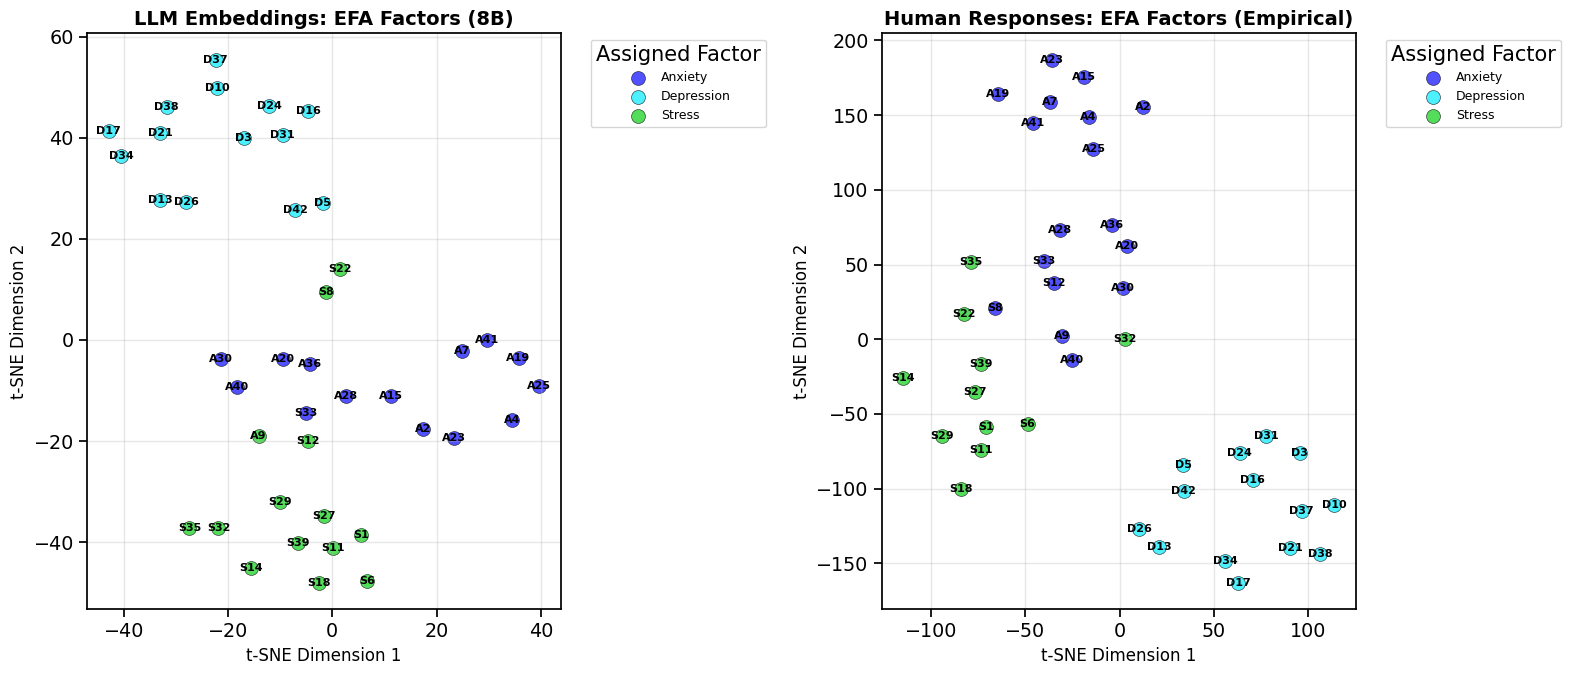

In [74]:
# ==============================================================================
# TSNE VISUALIZATION: EFA Factors Comparison (Embeddings vs Empirical)
# ==============================================================================

if empirical_data is not None and len(all_results) > 0 and 'all_tsne_embeddings' in dir() and 'empirical_2d' in dir():
    print(f"\n{'='*70}")
    print("TSNE VISUALIZATION: EFA Factors Comparison")
    print(f"{'='*70}")

    # Get first model
    model_size = list(all_tsne_embeddings.keys())[0]
    embeddings_2d = all_tsne_embeddings[model_size]

    # Get EFA factor assignments from both analyses
    embedding_assignments = all_results[model_size].get('daal_assignments')
    empirical_assignments = empirical_results.get('daal_assignments')

    if embedding_assignments is not None and empirical_assignments is not None:
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

        # Custom color palette
        custom_colors = ['#0907FF', '#00EAFF', '#0CCF14', '#FF2F00', '#C62FF4', '#F4B62F']

        # ======================================================================
        # LEFT PLOT: LLM Embeddings (EFA Factors)
        # ======================================================================

        # Create item -> extracted factor mapping for embeddings
        embedding_factor_map = {}
        for _, row in embedding_assignments.iterrows():
            assigned_factor = row['assigned_to']
            extracted_factor = row['extracted_factor']
            # Find all items that load highest on this extracted factor
            loadings_df = all_results[model_size]['loadings']
            for item_code in loadings_df.index:
                if loadings_df.loc[item_code].idxmax() == extracted_factor:
                    embedding_factor_map[item_code] = assigned_factor

        # Get unique factors and assign colors
        embedding_unique_factors = sorted(set(embedding_factor_map.values()))
        embedding_factor_colors = {factor: custom_colors[i % len(custom_colors)]
                                   for i, factor in enumerate(embedding_unique_factors)}

        # Plot points by factor
        for factor in embedding_unique_factors:
            indices = [i for i, code in enumerate(codes) if embedding_factor_map.get(code) == factor]
            if indices:
                ax1.scatter(
                    embeddings_2d[indices, 0],
                    embeddings_2d[indices, 1],
                    c=[embedding_factor_colors[factor]],
                    label=factor,
                    alpha=0.7,
                    s=100,
                    edgecolors='black',
                    linewidths=0.5
                )

        # Add item code labels
        for i in range(len(embeddings_2d)):
            ax1.annotate(
                codes[i],
                (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                fontsize=8,
                ha='center',
                va='center',
                fontweight='bold'
            )

        ax1.set_xlabel('t-SNE Dimension 1', fontsize=12)
        ax1.set_ylabel('t-SNE Dimension 2', fontsize=12)
        ax1.set_title(f'LLM Embeddings: EFA Factors ({model_size})', fontsize=14, fontweight='bold')
        ax1.legend(title='Assigned Factor', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
        ax1.grid(True, alpha=0.3)

        # ======================================================================
        # RIGHT PLOT: Human Responses (EFA Factors)
        # ======================================================================

        # Create item -> extracted factor mapping for empirical
        empirical_factor_map = {}
        for _, row in empirical_assignments.iterrows():
            assigned_factor = row['assigned_to']
            extracted_factor = row['extracted_factor']
            # Find all items that load highest on this extracted factor
            loadings_df = empirical_results['loadings']
            for item_code in loadings_df.index:
                if loadings_df.loc[item_code].idxmax() == extracted_factor:
                    empirical_factor_map[item_code] = assigned_factor

        # Get unique factors and assign colors (same colors as embeddings for matching factors)
        empirical_unique_factors = sorted(set(empirical_factor_map.values()))
        empirical_factor_colors = {factor: custom_colors[i % len(custom_colors)]
                                  for i, factor in enumerate(empirical_unique_factors)}

        # Plot points by factor
        for factor in empirical_unique_factors:
            indices = [i for i, code in enumerate(codes) if empirical_factor_map.get(code) == factor]
            if indices:
                ax2.scatter(
                    empirical_2d[indices, 0],
                    empirical_2d[indices, 1],
                    c=[empirical_factor_colors[factor]],
                    label=factor,
                    alpha=0.7,
                    s=100,
                    edgecolors='black',
                    linewidths=0.5
                )

        # Add item code labels
        for i in range(len(empirical_2d)):
            ax2.annotate(
                codes[i],
                (empirical_2d[i, 0], empirical_2d[i, 1]),
                fontsize=8,
                ha='center',
                va='center',
                fontweight='bold'
            )

        ax2.set_xlabel('t-SNE Dimension 1', fontsize=12)
        ax2.set_ylabel('t-SNE Dimension 2', fontsize=12)
        ax2.set_title('Human Responses: EFA Factors (Empirical)', fontsize=14, fontweight='bold')
        ax2.legend(title='Assigned Factor', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
        ax2.grid(True, alpha=0.3)

        # ======================================================================
        # Save and display
        # ======================================================================

        plt.tight_layout()

        # Save figure
        os.makedirs(SAVE_DIR, exist_ok=True)
        filename = f'{SCALE_NAME}_embeddings_vs_empirical_tsne_efa.png'
        filepath = f'{SAVE_DIR}/{filename}'
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"\n✓ TSNE EFA comparison saved to: {filepath}")

        plt.show()

    else:
        print("\n⚠ Factor assignments not available for comparison")
        print("  Both analyses need DAAL assignments to create EFA factor visualization")

else:
    print(f"\n{'='*70}")
    print("Skipping TSNE EFA comparison (requires both empirical and embedding data)")
    print(f"{'='*70}")


In [75]:
# ==============================================================================
# T-SNE COMPUTATION: Embedding Data
# ==============================================================================

# Import visualization libraries
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Prepare data for T-SNE
print(f"\n{'='*70}")
print("COMPUTING T-SNE FOR EMBEDDING DATA")
print(f"{'='*70}")
print(f"Number of items: {len(factors)}")
print(f"Number of models: {len(all_embeddings)}")

all_tsne_embeddings = {}

for model_size, embeddings in all_embeddings.items():
    print(f"\nProcessing {model_size}...")
    # Input shape (output suppressed) #embeddings.shape}")

    # Run T-SNE dimensionality reduction
    tsne = TSNE(verbose=0, 
        n_components=2,      # Reduce to 2D
        perplexity=10,       # Balance local vs global structure
        max_iter=1000,       # Max iterations
        random_state=42,     # Reproducibility
    )

    # Transform high-D embeddings to 2D
    embeddings_2d = tsne.fit_transform(embeddings)
    all_tsne_embeddings[model_size] = embeddings_2d

    # T-SNE complete (output suppressed) #embeddings_2d.shape}")

print(f"\n{'='*70}")
print(f"✓ T-SNE complete for all {len(all_tsne_embeddings)} models!")
print(f"{'='*70}")


In [76]:
# ==============================================================================
# T-SNE COMPUTATION: Empirical Data
# ==============================================================================

if empirical_data is not None:
    print(f"\n{'='*70}")
    print("COMPUTING T-SNE FOR EMPIRICAL DATA")
    print(f"{'='*70}")
    print(f"Input: {empirical_data.shape[0]:,} participants × {empirical_data.shape[1]} items")
    print(f"Transposing to: {empirical_data.shape[1]} items × {empirical_data.shape[0]:,} participants")

    # Transpose: items become rows, participants become columns
    empirical_transposed = empirical_data.T
    print(f"  Transposed shape: {empirical_transposed.shape}")
    print(f"\n  Running T-SNE on items in participant space...")
    print(f"  This visualizes item relationships based on human response patterns")

    # Run T-SNE
    tsne_emp = TSNE(verbose=0, 
        n_components=2,
        perplexity=10,
        max_iter=1000,
        random_state=42,
    )

    empirical_2d = tsne_emp.fit_transform(empirical_transposed)
    # T-SNE complete (output suppressed) # shape: {empirical_2d.shape}")

    print(f"\n{'='*70}")
    print("✓ EMPIRICAL T-SNE COMPUTATION COMPLETE")
    print(f"{'='*70}")

else:
    print(f"\n{'='*70}")
    print("Empirical data not available - skipping empirical t-SNE")
    print(f"{'='*70}")


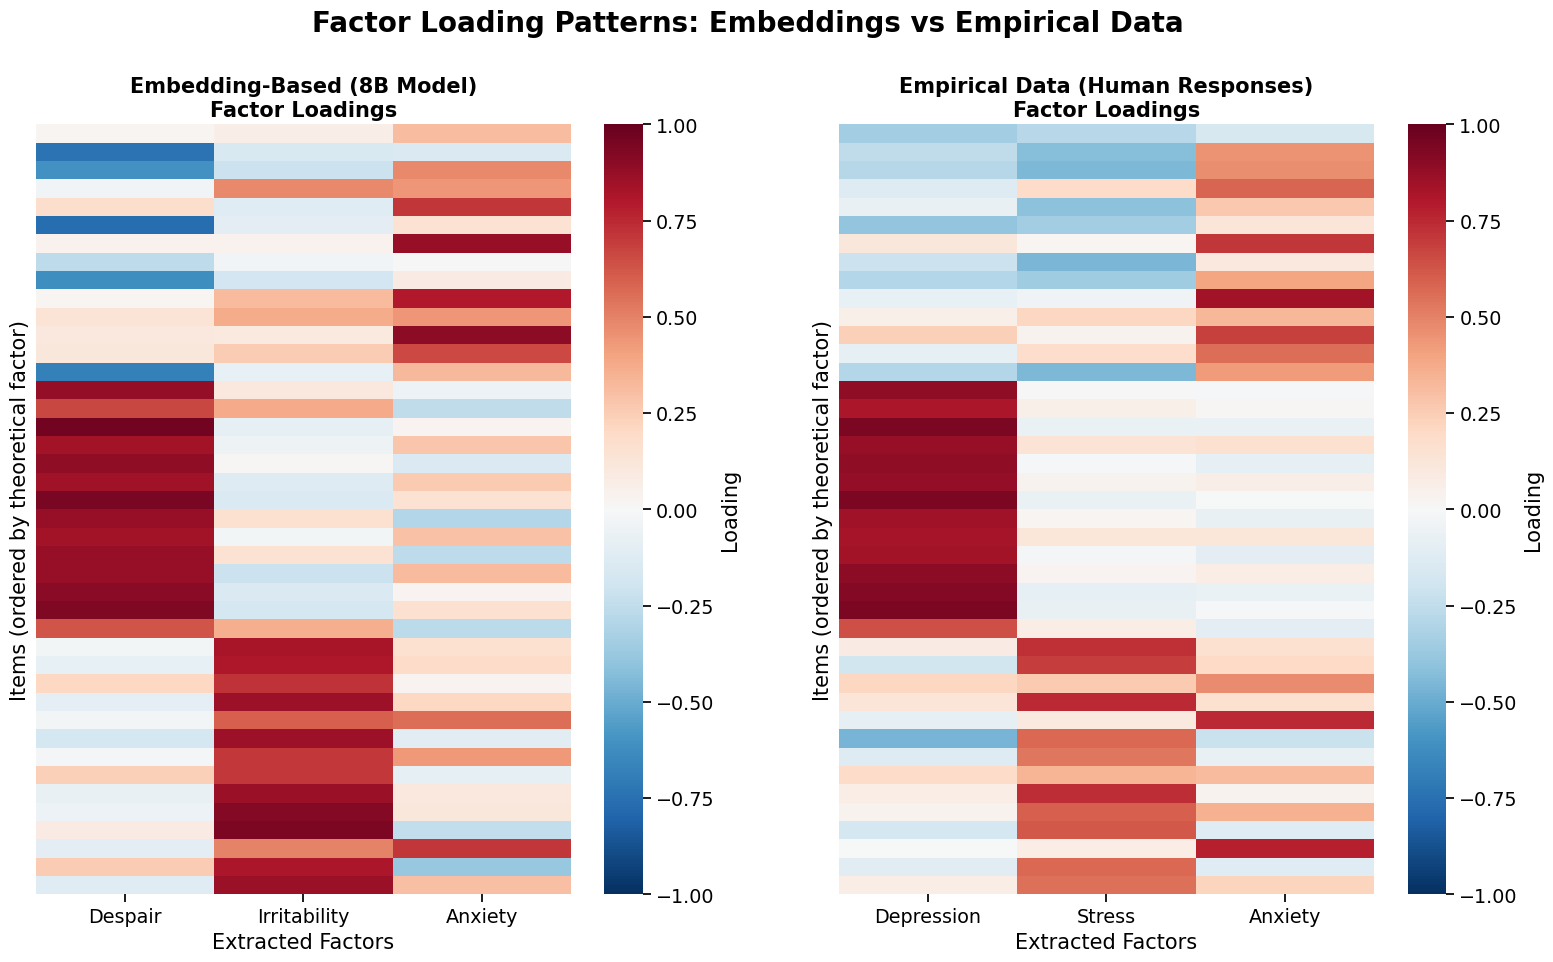

In [77]:
# ==============================================================================
# COMPARISON 2: Factor Loadings
# ==============================================================================

if empirical_results is not None and len(all_results) > 0:
    print(f"\n{'='*70}")
    print("COMPARISON: Factor Loadings")
    print(f"{'='*70}")
    
    # Get loadings from both analyses
    model_size = list(all_results.keys())[0]
    embedding_loadings = all_results[model_size]['loadings']
    empirical_loadings = empirical_results['loadings']
    
    # Get LLM-generated factor names for embedding plot
    if 'factor_name_mappings_nn' in dir() and model_size in factor_name_mappings_nn:
        embedding_factor_labels = [
            factor_name_mappings_nn[model_size].get(col, col) 
            for col in embedding_loadings.columns
        ]
    else:
        embedding_factor_labels = embedding_loadings.columns
    
    # Get theoretical factor names for empirical plot
    empirical_tucker_best = empirical_results.get('tucker_best')
    if empirical_tucker_best is not None:
        # Create mapping from extracted factor to theoretical factor
        empirical_factor_map = {}
        for _, row in empirical_tucker_best.iterrows():
            empirical_factor_map[row['extracted_factor']] = row['best_match']
        
        # Create labels for empirical plot
        empirical_factor_labels = [
            empirical_factor_map.get(col, col) 
            for col in empirical_loadings.columns
        ]
    else:
        empirical_factor_labels = empirical_loadings.columns
    
    # Create side-by-side comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18 + COMPARISON_SUBPLOT_SPACING, 10))
    
    # Order items by theoretical factors
    factor_order = sorted(range(len(factors)), key=lambda i: (factors[i], i))
    ordered_codes = [codes[i] for i in factor_order]
    
    embedding_ordered = embedding_loadings.loc[ordered_codes]
    empirical_ordered = empirical_loadings.loc[ordered_codes]
    
    # LEFT: Embedding-based Loadings
    sns.heatmap(embedding_ordered.values, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
               ax=ax1, cbar_kws={'label': 'Loading'},
               yticklabels=False, xticklabels=embedding_factor_labels)
    ax1.set_title(f'Embedding-Based ({model_size} Model)\nFactor Loadings', 
                  fontweight='bold')
    ax1.set_xlabel('Extracted Factors')
    ax1.set_ylabel('Items (ordered by theoretical factor)')
    ax1.tick_params(axis='x', rotation=0)
    
    # RIGHT: Empirical Loadings
    sns.heatmap(empirical_ordered.values, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
               ax=ax2, cbar_kws={'label': 'Loading'},
               yticklabels=False, xticklabels=empirical_factor_labels)
    ax2.set_title('Empirical Data (Human Responses)\nFactor Loadings', 
                  fontweight='bold')
    ax2.set_xlabel('Extracted Factors')
    ax2.set_ylabel('Items (ordered by theoretical factor)')
    ax2.tick_params(axis='x', rotation=0)
    
    # Overall title
    fig.suptitle('Factor Loading Patterns: Embeddings vs Empirical Data', 
                 fontweight='bold', y=0.995)
    
    
    # Save
    os.makedirs(SAVE_DIR, exist_ok=True)
    filepath = f'{SAVE_DIR}/comparison_loadings.png'
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"  ✓ Saved: {filepath}")
    
    # Compare variance explained
    embedding_variance = all_results[model_size]['variance'][2][-1]  # Cumulative
    empirical_variance = empirical_results['variance'][2][-1]
    
    print(f"\n  Variance Explained:")
    print(f"    Embeddings: {embedding_variance:.1%}")
    print(f"    Empirical:  {empirical_variance:.1%}")
    print(f"    Difference: {(empirical_variance - embedding_variance):.1%}")
    
else:
    print("\\nSkipping comparison - empirical results not available")

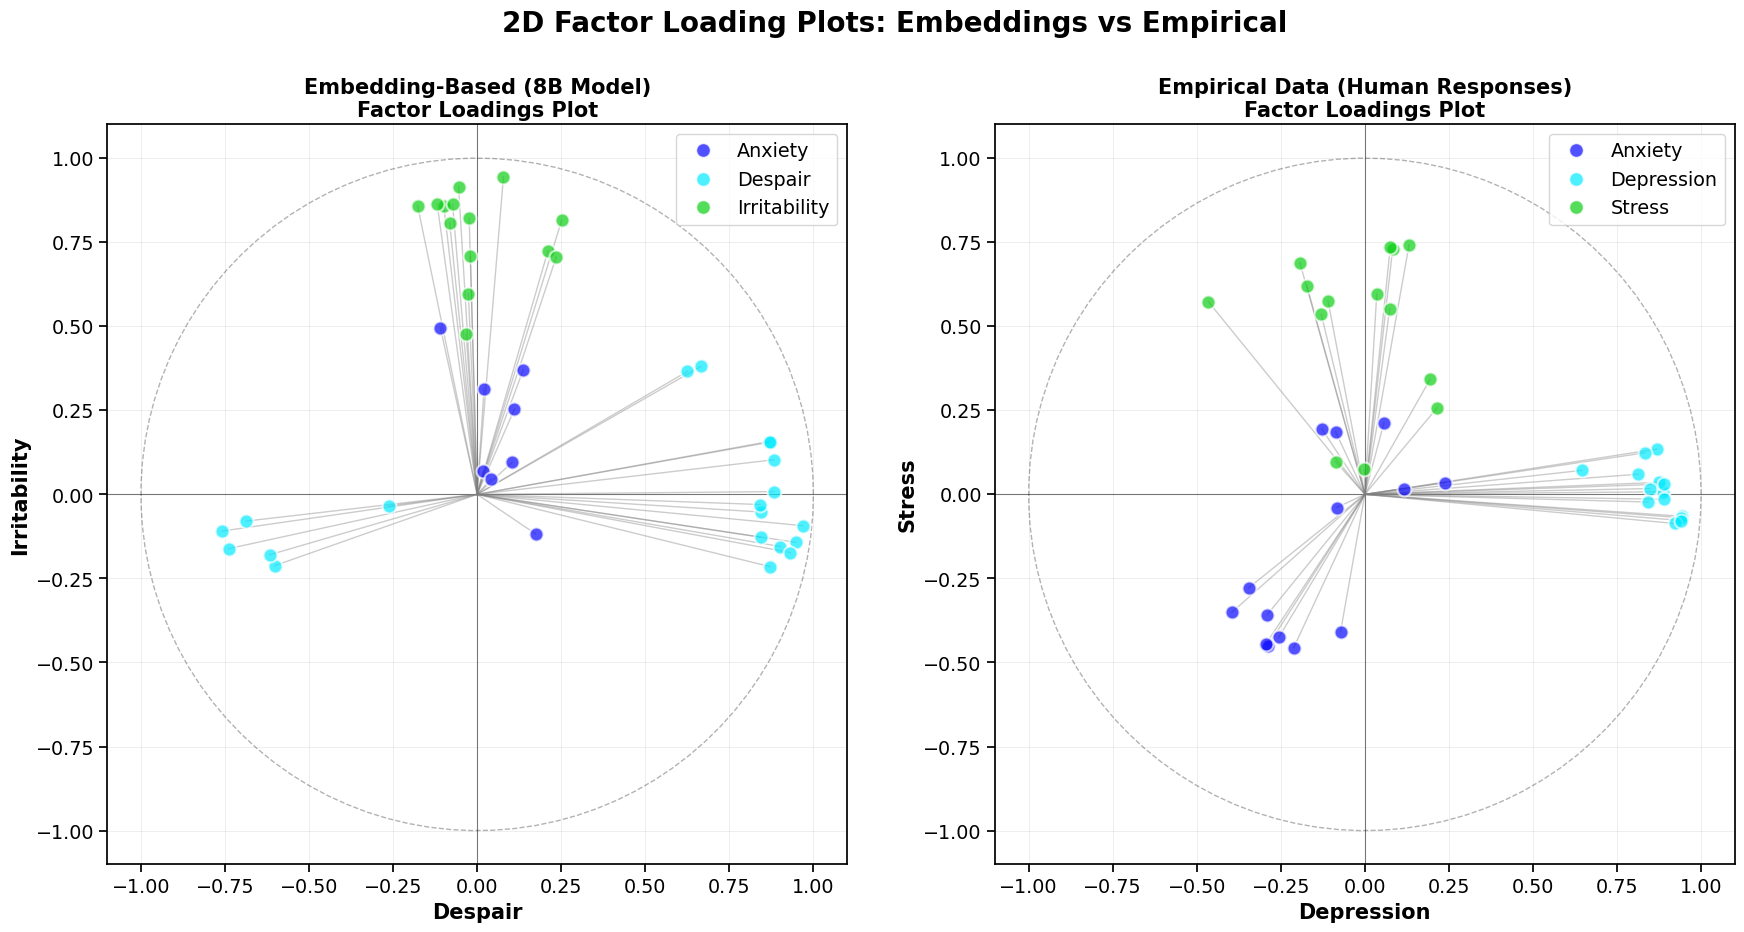

In [78]:
# ==============================================================================
# COMPARISON 2B: Factor Loadings on Theoretical Factors
# ==============================================================================

if empirical_results is not None and len(all_results) > 0:
    print(f"\n{'='*70}")
    print("COMPARISON: Item Loadings on Their Theoretical Factors")
    print(f"{'='*70}")
    
    # Get data
    model_size = list(all_results.keys())[0]
    embedding_loadings = all_results[model_size]['loadings']
    empirical_loadings = empirical_results['loadings']
    
    # Get factor mapping (extracted factor -> theoretical factor)
    embedding_tucker_best = all_results[model_size].get('tucker_best')
    empirical_tucker_best = empirical_results.get('tucker_best')
    
    if embedding_tucker_best is not None and empirical_tucker_best is not None:
        # Create mapping: theoretical_factor -> extracted_factor
        embedding_factor_map = {}
        for _, row in embedding_tucker_best.iterrows():
            embedding_factor_map[row['best_match']] = row['extracted_factor']
        
        empirical_factor_map = {}
        for _, row in empirical_tucker_best.iterrows():
            empirical_factor_map[row['best_match']] = row['extracted_factor']
        
        # Extract each item's loading on its theoretical factor
        embedding_theoretical_loadings = []
        empirical_theoretical_loadings = []
        item_labels = []
        theoretical_factors_list = []
        
        for i, (code, item_factor) in enumerate(zip(codes, factors)):
            # Get the extracted factor that corresponds to this item's theoretical factor
            embedding_extracted = embedding_factor_map.get(item_factor)
            empirical_extracted = empirical_factor_map.get(item_factor)
            
            if embedding_extracted and empirical_extracted:
                # Get loading on the corresponding extracted factor
                embedding_loading = embedding_loadings.loc[code, embedding_extracted]
                empirical_loading = empirical_loadings.loc[code, empirical_extracted]
                
                embedding_theoretical_loadings.append(embedding_loading)
                empirical_theoretical_loadings.append(empirical_loading)
                item_labels.append(code)
                theoretical_factors_list.append(item_factor)
        
        # Create 2D Factor Loading Plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20 + COMPARISON_SUBPLOT_SPACING, 10))
        
        # Get the first two factors for plotting
        embedding_factor_names = embedding_loadings.columns[:2]
        empirical_factor_names = empirical_loadings.columns[:2]
        
        # Custom color palette
        custom_colors = ['#0907FF', '#00EAFF', '#0CCF14', '#FF2F00', '#C62FF4', '#F4B62F']
        
        # Get LLM-generated factor names for embedding plot (if available)
        if 'factor_name_mappings_nn' in dir() and model_size in factor_name_mappings_nn:
            embedding_axis_labels = [
                factor_name_mappings_nn[model_size].get(embedding_factor_names[0], embedding_factor_names[0]),
                factor_name_mappings_nn[model_size].get(embedding_factor_names[1], embedding_factor_names[1])
            ]
        else:
            embedding_axis_labels = embedding_factor_names
        
        # Get factor assignments for coloring
        if 'factor_assignments' in dir() and model_size in factor_assignments:
            factor_items = factor_assignments[model_size]
            extracted_factor_names = sorted(factor_items.keys())
            
            # Create item -> extracted factor mapping
            item_to_extracted_factor = {}
            for factor_name in extracted_factor_names:
                for item in factor_items[factor_name]:
                    item_to_extracted_factor[item['code']] = factor_name
            
            # Get display names for extracted factors
            embedding_display_names = {}
            if 'factor_name_mappings_nn' in dir() and model_size in factor_name_mappings_nn:
                for factor_name in extracted_factor_names:
                    embedding_display_names[factor_name] = factor_name_mappings_nn[model_size].get(factor_name, factor_name)
            else:
                embedding_display_names = {f: f for f in extracted_factor_names}
            
            # Sort factors by display name and assign colors in that order
            sorted_extracted_factors = sorted(extracted_factor_names, key=lambda f: embedding_display_names[f])
            embedding_factor_colors = {factor: custom_colors[i % len(custom_colors)] 
                                      for i, factor in enumerate(sorted_extracted_factors)}
        else:
            # Fallback to theoretical factors if assignments not available
            item_to_extracted_factor = {code: factor for code, factor in zip(codes, factors)}
            extracted_factor_names = sorted(set(factors))
            embedding_display_names = {f: f for f in extracted_factor_names}
            sorted_extracted_factors = sorted(extracted_factor_names)
            embedding_factor_colors = {factor: custom_colors[i % len(custom_colors)] 
                                      for i, factor in enumerate(sorted_extracted_factors)}
        
        # For empirical plot, color by theoretical factors
        # Sort theoretical factors alphabetically and assign colors in that order
        empirical_factor_names_list = sorted(set(factors))
        empirical_factor_colors = {factor: custom_colors[i % len(custom_colors)] 
                                  for i, factor in enumerate(empirical_factor_names_list)}
        
        # Function to create 2D factor loading plot
        def plot_2d_loadings(ax, loadings_df, factor_names, axis_labels, title, 
                            item_colors_map, factor_list, display_names):
            # Draw unit circle
            theta = np.linspace(0, 2*np.pi, 100)
            circle_x = np.cos(theta)
            circle_y = np.sin(theta)
            ax.plot(circle_x, circle_y, 'k--', alpha=0.3, linewidth=1)
            
            # Draw axes
            ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
            ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
            
            # Plot each item
            for i, code in enumerate(codes):
                if code in loadings_df.index and code in item_colors_map:
                    x = loadings_df.loc[code, factor_names[0]]
                    y = loadings_df.loc[code, factor_names[1]]
                    
                    item_factor = item_colors_map[code]
                    
                    # Draw line from origin to point
                    ax.plot([0, x], [0, y], color='gray', alpha=0.4, linewidth=1)
                    
                    # Plot point
                    ax.scatter(x, y, c=[factor_list[item_factor]], s=100, 
                              alpha=0.7, edgecolors='white', linewidth=1.5, zorder=5)
            
            # Set labels and title
            ax.set_xlabel(axis_labels[0], fontweight='bold')
            ax.set_ylabel(axis_labels[1], fontweight='bold')
            ax.set_title(title, fontweight='bold')
            
            # Set equal aspect ratio and limits
            ax.set_aspect('equal')
            ax.set_xlim(-1.1, 1.1)
            ax.set_ylim(-1.1, 1.1)
            ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
            
            # Add legend (sorted alphabetically by display name)
            sorted_factors = sorted(factor_list.keys(), key=lambda f: display_names[f])
            legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                         markerfacecolor=factor_list[f], 
                                         markersize=10, label=display_names[f], alpha=0.7)
                              for f in sorted_factors]
            ax.legend(handles=legend_elements, loc='best')
        
        # LEFT: Embedding-based loadings (colored by extracted factors with LLM names)
        plot_2d_loadings(ax1, embedding_loadings, embedding_factor_names, embedding_axis_labels,
                        f'Embedding-Based ({model_size} Model)\nFactor Loadings Plot',
                        item_to_extracted_factor, embedding_factor_colors, embedding_display_names)
        
        # RIGHT: Empirical loadings (colored by theoretical factors)
        item_to_theoretical = {code: factor for code, factor in zip(codes, factors)}
        empirical_display_names = {f: f for f in empirical_factor_names_list}
        
        # Map empirical extracted factors to their theoretical factor names for axis labels
        empirical_axis_labels = []
        for factor_name in empirical_factor_names:
            # Find which theoretical factor this extracted factor best matches
            best_match = None
            for theo_factor, extracted_factor in empirical_factor_map.items():
                if extracted_factor == factor_name:
                    best_match = theo_factor
                    break
            empirical_axis_labels.append(best_match if best_match else factor_name)
        
        plot_2d_loadings(ax2, empirical_loadings, empirical_factor_names, empirical_axis_labels,
                        'Empirical Data (Human Responses)\nFactor Loadings Plot',
                        item_to_theoretical, empirical_factor_colors, empirical_display_names)
        
        # Overall title
        fig.suptitle('2D Factor Loading Plots: Embeddings vs Empirical', 
                     fontweight='bold', y=0.98)
        
        
        # Save
        os.makedirs(SAVE_DIR, exist_ok=True)
        filepath = f'{SAVE_DIR}/comparison_2d_factor_loadings.png'
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"  ✓ Saved: {filepath}")
        
        # Print factor information
        print(f"\n  Factor Pair Visualized:")
        print(f"    Embeddings: {embedding_axis_labels[0]} vs {embedding_axis_labels[1]}")
        print(f"    Empirical:  {empirical_axis_labels[0]} vs {empirical_axis_labels[1]}")

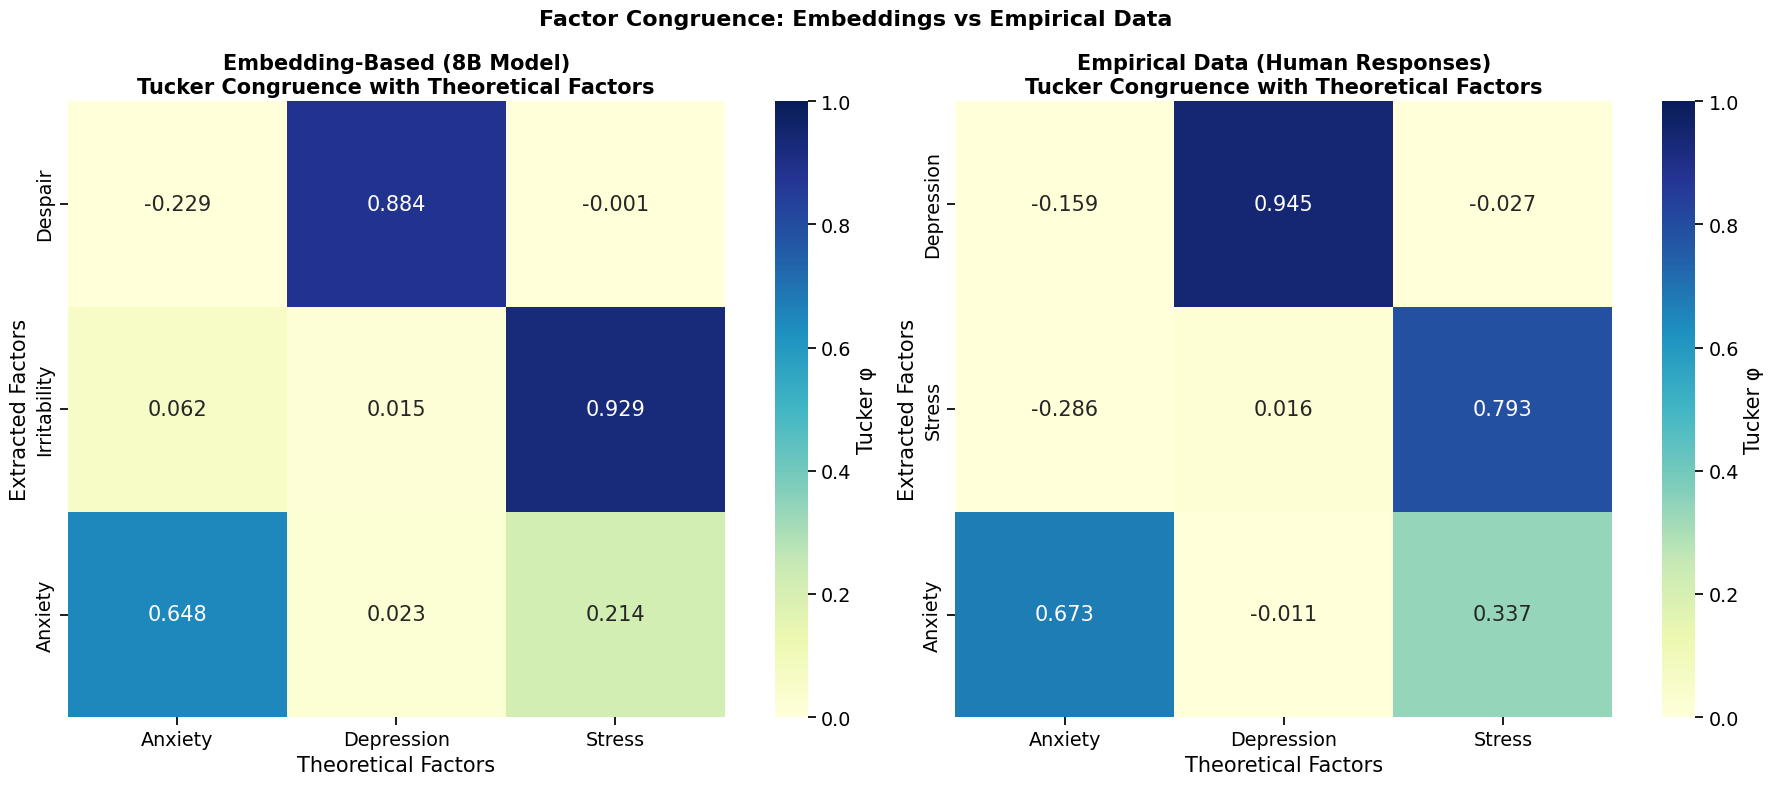

In [79]:
# ==============================================================================
# COMPARISON 3: Tucker Congruence
# ==============================================================================

if empirical_results is not None and len(all_results) > 0:
    print(f"\n{'='*70}")
    print("COMPARISON: Tucker Congruence")
    print(f"{'='*70}")
    
    # Get Tucker congruence from both analyses
    model_size = list(all_results.keys())[0]
    embedding_tucker = all_results[model_size]['tucker']
    empirical_tucker = empirical_results['tucker']
    
    # Get LLM-generated factor names for embedding plot
    if 'factor_name_mappings_nn' in dir() and model_size in factor_name_mappings_nn:
        embedding_factor_labels = [
            factor_name_mappings_nn[model_size].get(idx, idx) 
            for idx in embedding_tucker.index
        ]
    else:
        embedding_factor_labels = embedding_tucker.index
    
    # Get theoretical factor names for empirical plot y-axis
    empirical_tucker_best = empirical_results.get('tucker_best')
    if empirical_tucker_best is not None:
        # Create mapping from extracted factor to theoretical factor
        empirical_factor_map = {}
        for _, row in empirical_tucker_best.iterrows():
            empirical_factor_map[row['extracted_factor']] = row['best_match']
        
        # Create labels for empirical plot
        empirical_factor_labels = [
            empirical_factor_map.get(idx, idx) 
            for idx in empirical_tucker.index
        ]
    else:
        empirical_factor_labels = empirical_tucker.index
    
    # Create side-by-side comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20 + COMPARISON_SUBPLOT_SPACING, 8))

    # Create colorbars with proper sizing
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # Create dividers for proper colorbar placement
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.5)

    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.5)

    # LEFT: Embedding-based Tucker
    sns.heatmap(embedding_tucker.values, annot=True, annot_kws={'fontsize': 15}, fmt='.3f', cmap='YlGnBu',
               xticklabels=embedding_tucker.columns, yticklabels=embedding_factor_labels,
               ax=ax1, vmin=0, vmax=1, cbar_ax=cax1, cbar_kws={'label': 'Tucker φ'})
    ax1.set_title(f'Embedding-Based ({model_size} Model)\nTucker Congruence with Theoretical Factors', 
                  fontweight='bold')
    ax1.set_xlabel('Theoretical Factors')
    ax1.set_ylabel('Extracted Factors')
    
    # RIGHT: Empirical Tucker
    sns.heatmap(empirical_tucker.values, annot=True, annot_kws={'fontsize': 15}, fmt='.3f', cmap='YlGnBu',
               xticklabels=empirical_tucker.columns, yticklabels=empirical_factor_labels,
               ax=ax2, vmin=0, vmax=1, cbar_ax=cax2, cbar_kws={'label': 'Tucker φ'})
    ax2.set_title('Empirical Data (Human Responses)\nTucker Congruence with Theoretical Factors', 
                  fontweight='bold')
    ax2.set_xlabel('Theoretical Factors')
    ax2.set_ylabel('Extracted Factors')
    
    # Overall title
    fig.suptitle('Factor Congruence: Embeddings vs Empirical Data',
                 fontsize=16, fontweight='bold', y=0.995)
    
    
    # Save
    os.makedirs(SAVE_DIR, exist_ok=True)
    filepath = f'{SAVE_DIR}/comparison_tucker.png'
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"  ✓ Saved: {filepath}")
    
    # Compare best matches
    embedding_best = all_results[model_size]['tucker_best']
    empirical_best = empirical_results['tucker_best']
    
    print(f"\n  Best Tucker Matches:")
    print(f"    {'Factor':<12} {'Embeddings':<25} {'Empirical':<25}")
    print(f"    {'-'*12} {'-'*25} {'-'*25}")
    
    for i in range(min(len(embedding_best), len(empirical_best))):
        emb_row = embedding_best.iloc[i]
        emp_row = empirical_best.iloc[i]
        print(f"    {emb_row['extracted_factor']:<12} {emb_row['best_match']:<15} (φ={emb_row['tucker_phi']:.3f})   "
              f"{emp_row['best_match']:<15} (φ={emp_row['tucker_phi']:.3f})")
    
    # Count matches where both methods agree
    emb_matches = {row['extracted_factor']: row['best_match'] for _, row in embedding_best.iterrows()}
    emp_matches = {row['extracted_factor']: row['best_match'] for _, row in empirical_best.iterrows()}
    
    agreement_count = sum(1 for k in emb_matches if k in emp_matches and emb_matches[k] == emp_matches[k])
    total_factors = len(emb_matches)
    
    print(f"\n  Agreement: {agreement_count}/{total_factors} factors assigned to same theoretical factor")
    
else:
    print("\\nSkipping comparison - empirical results not available")

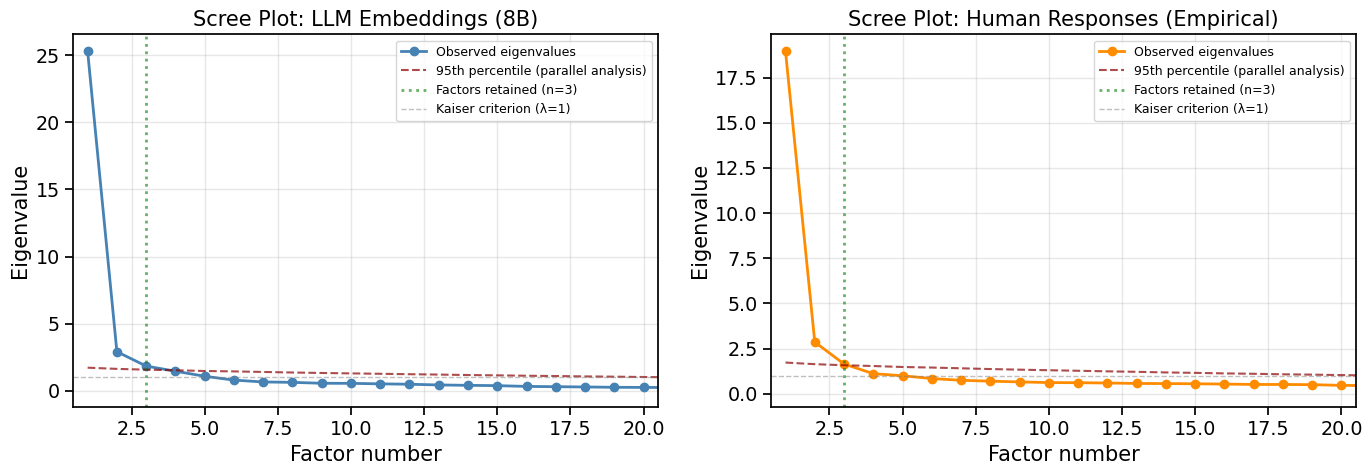

In [80]:
# ==============================================================================
# COMPARISON 4: Scree Plots
# ==============================================================================

if empirical_results is not None and len(all_results) > 0:
    print(f"\n{'='*70}")
    print("COMPARISON: Scree Plots")
    print(f"{'='*70}")

    # Get first model for embedding comparison
    model_size = list(all_results.keys())[0]
    emb_eigenvalues = all_results[model_size]['observed_eigenvalues']
    emp_eigenvalues = empirical_results['observed_eigenvalues']

    # Get parallel analysis percentile eigenvalues if available
    emb_percentile = all_results[model_size].get('percentile_eigenvalues', None)
    emp_percentile = empirical_results.get('percentile_eigenvalues', None)

    # Get number of factors retained
    emb_n_factors = all_results[model_size]['n_factors']
    emp_n_factors = empirical_results['n_factors']

    # Create scree plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Embedding eigenvalues
    n_eigs = len(emb_eigenvalues)
    x_vals = np.arange(1, n_eigs + 1)

    ax1.plot(x_vals, emb_eigenvalues, 'o-', color='steelblue', linewidth=2,
             markersize=6, label='Observed eigenvalues')

    if emb_percentile is not None:
        ax1.plot(x_vals, emb_percentile, '--', color='darkred', linewidth=1.5,
                 alpha=0.7, label='95th percentile (parallel analysis)')

    # Add vertical line at retained factors
    ax1.axvline(x=emb_n_factors, color='green', linestyle=':', linewidth=2,
                alpha=0.6, label=f'Factors retained (n={emb_n_factors})')

    # Add horizontal line at eigenvalue = 1
    ax1.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.5,
                label='Kaiser criterion (λ=1)')

    ax1.set_xlabel('Factor number')
    ax1.set_ylabel('Eigenvalue')
    ax1.set_title(f'Scree Plot: LLM Embeddings ({model_size})')
    ax1.legend(loc='upper right', fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0.5, min(20, n_eigs) + 0.5)  # Show first 20 factors

    # Plot 2: Empirical eigenvalues
    ax2.plot(x_vals, emp_eigenvalues, 'o-', color='darkorange', linewidth=2,
             markersize=6, label='Observed eigenvalues')

    if emp_percentile is not None:
        ax2.plot(x_vals, emp_percentile, '--', color='darkred', linewidth=1.5,
                 alpha=0.7, label='95th percentile (parallel analysis)')

    # Add vertical line at retained factors
    ax2.axvline(x=emp_n_factors, color='green', linestyle=':', linewidth=2,
                alpha=0.6, label=f'Factors retained (n={emp_n_factors})')

    # Add horizontal line at eigenvalue = 1
    ax2.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.5,
                label='Kaiser criterion (λ=1)')

    ax2.set_xlabel('Factor number')
    ax2.set_ylabel('Eigenvalue')
    ax2.set_title('Scree Plot: Human Responses (Empirical)')
    ax2.legend(loc='upper right', fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0.5, min(20, n_eigs) + 0.5)  # Show first 20 factors

    plt.tight_layout()

    # Save figure
    os.makedirs(SAVE_DIR, exist_ok=True)
    filename = f'{SCALE_NAME}_embeddings_vs_empirical_scree.png'
    filepath = f'{SAVE_DIR}/{filename}'
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"\n✓ Scree plots saved to: {filepath}")

    # Print summary
    print(f"\nEigenvalue Summary:")
    print(f"  LLM Embeddings ({model_size}):")
    print(f"    First eigenvalue: {emb_eigenvalues[0]:.2f}")
    print(f"    Factors retained: {emb_n_factors}")
    print(f"  Human Responses (Empirical):")
    print(f"    First eigenvalue: {emp_eigenvalues[0]:.2f}")
    print(f"    Factors retained: {emp_n_factors}")

    plt.show()

else:
    print("\nSkipping scree plot comparison (requires both empirical and embedding results)")


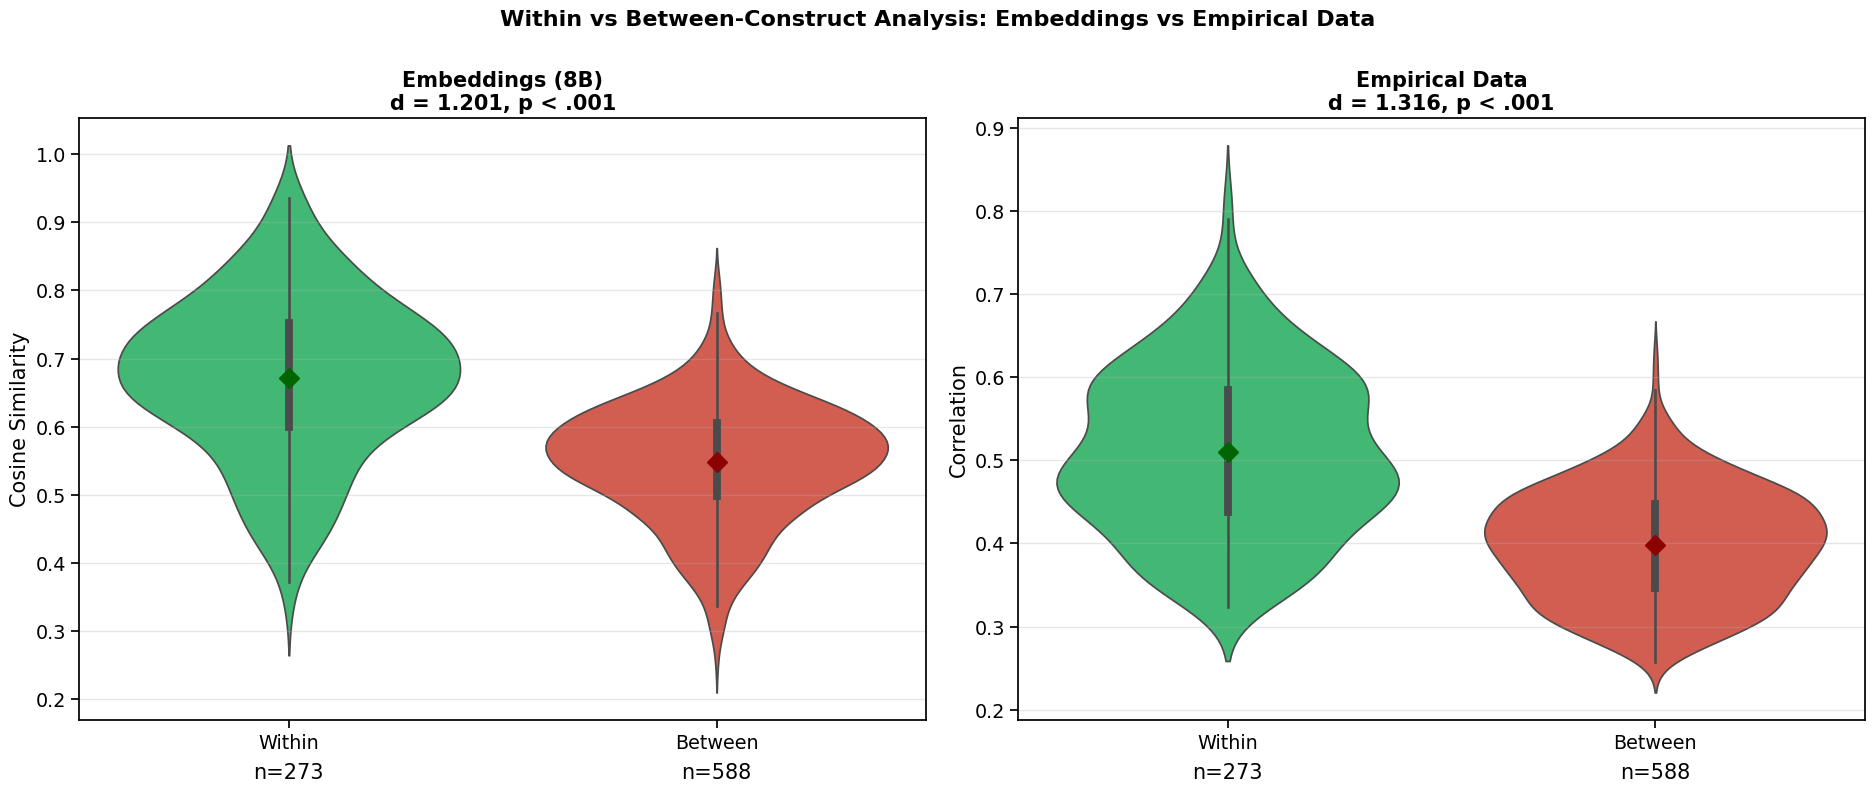

In [81]:
# ==============================================================================
# COMPARISON 5: Within vs Between-Construct Analysis
# ==============================================================================

if empirical_results is not None and len(all_results) > 0:
    print(f"\n{'='*70}")
    print("COMPARISON: Within vs Between-Construct Analysis")
    print(f"{'='*70}")
    
    # Get first model for embedding comparison
    model_size = list(all_results.keys())[0]
    embedding_sim = all_results[model_size]['similarity_matrix']
    empirical_corr = empirical_results['similarity_matrix']
    
    # Collect within/between for embeddings
    n_items = len(codes)
    emb_within = []
    emb_between = []
    emp_within = []
    emp_between = []
    
    for i in range(n_items):
        for j in range(i + 1, n_items):
            if factors[i] == factors[j]:
                emb_within.append(embedding_sim[i, j])
                emp_within.append(empirical_corr[i, j])
            else:
                emb_between.append(embedding_sim[i, j])
                emp_between.append(empirical_corr[i, j])
    
    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18 + COMPARISON_SUBPLOT_SPACING, 8))
    
    # Compute statistics for both
    from scipy.stats import ttest_ind
    
    # Embeddings stats
    emb_t, emb_p = ttest_ind(emb_within, emb_between, equal_var=False)
    emb_mean_w = np.mean(emb_within)
    emb_mean_b = np.mean(emb_between)
    emb_d = (emb_mean_w - emb_mean_b) / np.sqrt((np.std(emb_within)**2 + np.std(emb_between)**2) / 2)
    
    # Empirical stats
    emp_t, emp_p = ttest_ind(emp_within, emp_between, equal_var=False)
    emp_mean_w = np.mean(emp_within)
    emp_mean_b = np.mean(emp_between)
    emp_d = (emp_mean_w - emp_mean_b) / np.sqrt((np.std(emp_within)**2 + np.std(emp_between)**2) / 2)
    
    # TOP LEFT: Embedding violin plot
    emb_data = pd.DataFrame({
        'value': emb_within + emb_between,
        'type': ['Within'] * len(emb_within) + ['Between'] * len(emb_between)
    })
    sns.violinplot(data=emb_data, x='type', y='value', hue='type', ax=ax1, palette=['#2ecc71', '#e74c3c'], legend=False)
    ax1.plot([0], [emb_mean_w], 'D', color='darkgreen', markersize=10)
    ax1.plot([1], [emb_mean_b], 'D', color='darkred', markersize=10)
    y_offset = (ax1.get_ylim()[1] - ax1.get_ylim()[0]) * 0.07
    ax1.text(0, ax1.get_ylim()[0] - y_offset, f'n={len(emb_within)}', ha='center', va='top')
    ax1.text(1, ax1.get_ylim()[0] - y_offset, f'n={len(emb_between)}', ha='center', va='top')
    ax1.set_title(f'Embeddings ({model_size})\nd = {emb_d:.3f}, p < .001' if emb_p < 0.001 else f'Embeddings ({model_size})\nd = {emb_d:.3f}, p = {emb_p:.3f}',
                  fontweight='bold')
    ax1.set_ylabel('Cosine Similarity')
    ax1.set_xlabel('')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # TOP RIGHT: Empirical violin plot
    emp_data = pd.DataFrame({
        'value': emp_within + emp_between,
        'type': ['Within'] * len(emp_within) + ['Between'] * len(emp_between)
    })
    sns.violinplot(data=emp_data, x='type', y='value', hue='type', ax=ax2, palette=['#2ecc71', '#e74c3c'], legend=False)
    ax2.plot([0], [emp_mean_w], 'D', color='darkgreen', markersize=10)
    ax2.plot([1], [emp_mean_b], 'D', color='darkred', markersize=10)
    y_offset = (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.07
    ax2.text(0, ax2.get_ylim()[0] - y_offset, f'n={len(emp_within)}', ha='center', va='top')
    ax2.text(1, ax2.get_ylim()[0] - y_offset, f'n={len(emp_between)}', ha='center', va='top')
    ax2.set_title(f'Empirical Data\nd = {emp_d:.3f}, p < .001' if emp_p < 0.001 else f'Empirical Data\nd = {emp_d:.3f}, p = {emp_p:.3f}',
                  fontweight='bold')
    ax2.set_ylabel('Correlation')
    ax2.set_xlabel('')
    ax2.grid(True, alpha=0.3, axis='y')

    # Overall title
    fig.suptitle('Within vs Between-Construct Analysis: Embeddings vs Empirical Data',
                 fontsize=16, fontweight='bold', y=0.995)

    plt.tight_layout()

    # Save
    os.makedirs(SAVE_DIR, exist_ok=True)
    filepath = f'{SAVE_DIR}/comparison_within_between.png'
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"  ✓ Saved: {filepath}")
    
    # Summary statistics
    print(f"\n  Summary Statistics:")
    print(f"    {'Metric':<30} {'Embeddings':<15} {'Empirical':<15}")
    print(f"    {'-'*30} {'-'*15} {'-'*15}")
    print(f"    {'Within mean':<30} {emb_mean_w:<15.3f} {emp_mean_w:<15.3f}")
    print(f"    {'Between mean':<30} {emb_mean_b:<15.3f} {emp_mean_b:<15.3f}")
    print(f"    {'Difference':<30} {emb_mean_w - emb_mean_b:<15.3f} {emp_mean_w - emp_mean_b:<15.3f}")
    cohens_d_label = "Cohen's d"
    print(f"    {cohens_d_label:<30} {emb_d:<15.3f} {emp_d:<15.3f}")
    print(f"    {'t-statistic':<30} {emb_t:<15.3f} {emp_t:<15.3f}")
    print(f"    {'p-value':<30} {emb_p:<15.2e} {emp_p:<15.2e}")
    
else:
    print("\\nSkipping comparison - empirical results not available")

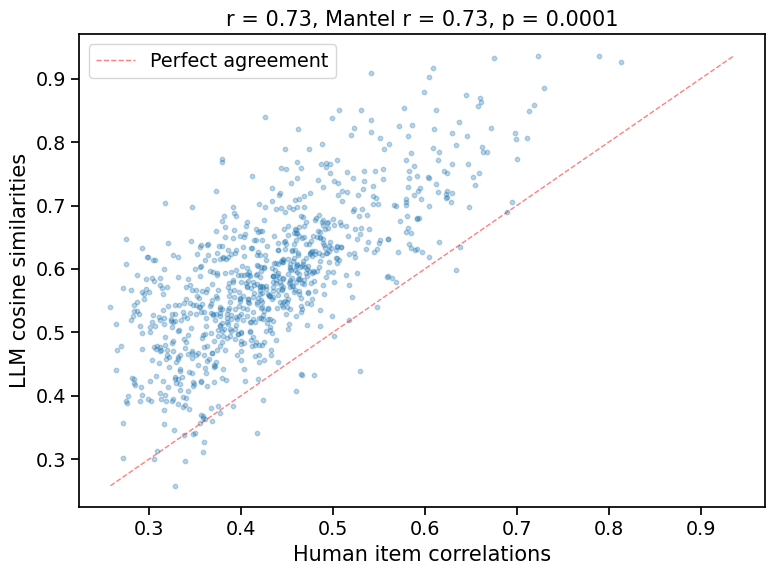

In [82]:
# ==============================================================================
# COMPARISON 6: Matrix-Level Correlation and Mantel Test
# ==============================================================================

if empirical_results is not None and len(all_results) > 0:
    print(f"\n{'='*70}")
    print("COMPARISON: Matrix-Level Correlation Analysis")
    print(f"{'='*70}\n")
    
    # Get first model for embedding comparison
    model_size = list(all_results.keys())[0]
    
    # Extract similarity matrices
    llm_similarity = all_results[model_size]['similarity_matrix']
    human_correlation = empirical_results['similarity_matrix']
    
    # Extract lower triangle (excluding diagonal) for pairwise comparisons
    n_items = llm_similarity.shape[0]
    mask = np.tril(np.ones((n_items, n_items), dtype=bool), k=-1)
    
    llm_cos = llm_similarity[mask]
    human_corr = human_correlation[mask]
    
    # Calculate Pearson correlation coefficient
    r, p_pearson = stats.pearsonr(llm_cos, human_corr)
    r_squared = r ** 2
    
    # Calculate Mantel test (requires distance matrices, so we'll use 1 - similarity)
    # Make copies to avoid modifying original data
    llm_dist = 1 - llm_similarity.copy()
    human_dist = 1 - human_correlation.copy()
    
    # Ensure matrices are symmetric (force symmetry by averaging with transpose)
    llm_dist = (llm_dist + llm_dist.T) / 2
    human_dist = (human_dist + human_dist.T) / 2
    
    # Ensure diagonal is exactly zero (required by scikit-bio)
    np.fill_diagonal(llm_dist, 0)
    np.fill_diagonal(human_dist, 0)
    
    # Replace any NaNs with 0 (shouldn't happen, but just in case)
    llm_dist = np.nan_to_num(llm_dist, nan=0.0)
    human_dist = np.nan_to_num(human_dist, nan=0.0)
    
    # Run Mantel test with 10,000 permutations
    # Returns: correlation coefficient, p-value, and number of items
    r_mantel, p_mantel, n_items_compared = mantel(
        llm_dist, 
        human_dist, 
        method='pearson',
        permutations=10000,
        alternative='greater'
    )
    
    # Print results
    print(f"Pairwise Correlation Analysis:")
    print(f"  Pearson r: {r:.4f}")
    print(f"  R²: {r_squared:.4f}")
    print(f"  p-value: {p_pearson:.4e}")
    print(f"\nMantel Test Results:")
    print(f"  Mantel r: {r_mantel:.4f}")
    print(f"  p-value: {p_mantel:.4f}")
    print(f"  Items compared: {n_items_compared}")
    print(f"  Permutations: 10,000")
    
    # Create scatterplot
    plt.figure(figsize=(8, 6))
    plt.scatter(human_corr, llm_cos, alpha=0.3, s=10)
    plt.xlabel("Human item correlations")
    plt.ylabel("LLM cosine similarities")
    plt.title(f"r = {r:.2f}, Mantel r = {r_mantel:.2f}, p = {p_mantel:.3g}")
    
    # Add diagonal reference line
    min_val = min(human_corr.min(), llm_cos.min())
    max_val = max(human_corr.max(), llm_cos.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, linewidth=1, label='Perfect agreement')
    plt.legend()
    
    plt.tight_layout()
    
    # Save figure
    os.makedirs(SAVE_DIR, exist_ok=True)
    filename = f'{SCALE_NAME}_embeddings_vs_empirical_correlation.png'
    filepath = f'{SAVE_DIR}/{filename}'
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"\nPlot saved to: {filepath}")
    
    plt.show()
    
else:
    print("\nSkipping matrix-level correlation analysis (requires both empirical and embedding results)")

In [83]:
# ==============================================================================
# ANALYSIS COMPLETE
# ==============================================================================

print(f"\n{'='*80}")
print(f"ANALYSIS COMPLETE: {SCALE_NAME}")
print(f"{'='*80}")
print(f"\nResults saved to: {SAVE_DIR}/")
print(f"Log file: {log_file_path}")
print(f"\nAnalysis completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"{'='*80}\n")

# Close logger and restore stdout
if 'logger' in dir() and hasattr(logger, 'close'):
    logger.close()
    sys.stdout = logger.terminal
    print(f"✓ Log saved to: {log_file_path}")

# If processing multiple scales, update CURRENT_SCALE_INDEX in cell 9 and re-run all cells
if len(SCALE_NAMES) > 1:
    print(f"\nTo process another scale:")
    print(f"  1. Update CURRENT_SCALE_INDEX in Cell 9")
    print(f"  2. Run all cells again")
    print(f"\nScales available: {SCALE_NAMES}")
